* Files
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Let`s import all packages that we may need:

import sys 
import time
import itertools
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pip install keras-tcn

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [4]:
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

In [5]:
from keras import Input, Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D,  Dense, concatenate, Multiply
from keras.activations import relu


In [6]:
from google.colab import files

# Load Datasets

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Data/household_power_consumption.txt',
                 sep = ';', parse_dates = {'dt' : ['Date', 'Time']}, infer_datetime_format = True,
                 low_memory = False, na_values = ['nan','?'], index_col = 'dt')

In [8]:
df.head() 

Global_active_power  ...  Sub_metering_3
dt                                        ...                
2006-12-16 17:24:00                4.216  ...            17.0
2006-12-16 17:25:00                5.360  ...            16.0
2006-12-16 17:26:00                5.374  ...            17.0
2006-12-16 17:27:00                5.388  ...            17.0
2006-12-16 17:28:00                3.666  ...            17.0

[5 rows x 7 columns]

In [9]:
tf.random.set_seed(1234)

In [10]:
# Check for na values
df.isna().sum()
# Readings for 25979 observations missing

# Check the proportion of missing values

df.isna().sum()/df.shape[0]

Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [11]:
def fill_missing(dat):
    window = 60 * 24
    for row in range(dat.shape[0]):
        for col in range(dat.shape[1]):
            if np.isnan(dat[row,col]):
                dat[row, col] = dat[row - window, col]

In [12]:
fill_missing(df.values)
df.isna().sum()
#df.head()
#df.info()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

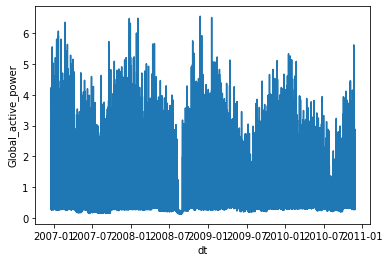

In [13]:
# As our focus is on getting a read on daily consumption it is a good idea
# to downsample the data to daily readings

df_resampled_hourly_avg = df.resample('H').mean()
df_resampled_hourly_avg.head()
df_resampled_hourly_avg.shape
# 34589,7
sns.lineplot(data=df_resampled_hourly_avg, y='Global_active_power',
             x=df_resampled_hourly_avg.index)

df_resample = df_resampled_hourly_avg.resample('D').mean()

* Data resampled at day level just for comparison


In [14]:
## resampling of data over hour
#df_resample = df.resample('D').mean() 
print(df_resample) 
df_resample.shape

            Global_active_power  ...  Sub_metering_3
dt                               ...                
2006-12-16             3.120298  ...       12.692063
2006-12-17             2.354486  ...        9.264583
2006-12-18             1.530435  ...        9.734722
2006-12-19             1.157079  ...        4.303472
2006-12-20             1.545658  ...        9.765972
...                         ...  ...             ...
2010-11-22             1.417733  ...        7.038889
2010-11-23             1.095511  ...        5.285417
2010-11-24             1.247394  ...        8.488889
2010-11-25             0.993864  ...        3.522222
2010-11-26             1.167712  ...        7.567424

[1442 rows x 7 columns]


(1442, 7)

In [15]:
import calendar
calendar.day_name[df_resample.index.weekday[0]]

'Saturday'

* Starting day in data is a **Saturday**
* We will remove first 2 observations so that data starts from Monday, so that it is easy to visualize a weekly seasonality if it exists

In [16]:
df_resample_sliced = df_resample[2:]
df_resample_sliced.shape
calendar.day_name[df_resample_sliced.index.weekday[0]]

'Monday'

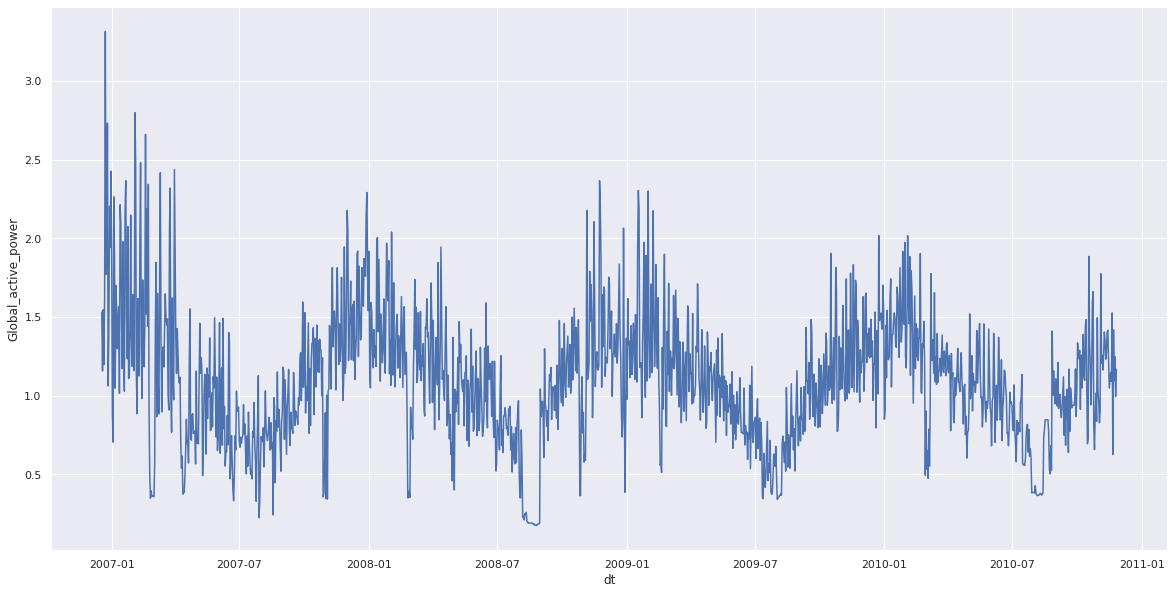

In [17]:
sns.set_theme()
fig, ax = plt.subplots(figsize = (20,10))
sns.lineplot(data = df_resample_sliced, y = 'Global_active_power', x = df_resample_sliced.index)

**Active power usage by Month**

In [18]:
df_resample_sliced.groupby(df_resample_sliced.index.strftime('%b'), sort = False)['Global_active_power'].mean()

dt
Dec    1.477656
Jan    1.460179
Feb    1.300928
Mar    1.230836
Apr    1.039632
May    1.029559
Jun    0.906512
Jul    0.700587
Aug    0.583312
Sep    0.974386
Oct    1.137197
Nov    1.291483
Name: Global_active_power, dtype: float64

* We can clearly see that there is a monthly seasonality present in power consumed by appliances(Global active power
* Usage drops around middle of the year and peaking towards the end of year

In [19]:
df_resample_sliced.groupby(df_resample_sliced.index.strftime('%a'), sort = False)['Global_active_power'].mean()

dt
Mon    0.997309
Tue    1.069351
Wed    1.082994
Thu    0.980880
Fri    1.042470
Sat    1.238724
Sun    1.206729
Name: Global_active_power, dtype: float64

* Usage peaks around weekend and weekday usage more or less remains similar which is what we are expecting 

In [20]:

df_resample_day = df_resample_sliced


df_resample_day.head()

# Min and Max dates
df_resample_day.index.min()
# 2006-12-18
df_resample_day.index.max()
# 2010-11-26

df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]

df_resample_day_y.head()
print(type(df_resample_day_y))

<class 'pandas.core.frame.DataFrame'>


In [21]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]

In [22]:
df_resample_day.to_csv("household_power_consumption_daily.csv")
#files.download("household_power_consumption_daily.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Function Definitions

## General Function Definitions

In [23]:
def scale_data(dat, range =(0,1)):
  ## * Note: I scale all features in range of [0,1].

  ## If you would like to train based on the resampled data (over hour), then used below
  values = dat.values
  # normalize features
  scaler = MinMaxScaler(feature_range=range)
  scaled = scaler.fit_transform(values)

  #print(type(scaled))
  print("Shape of scaled dataset-",scaled.shape)
  #print(pd.DataFrame(scaled))

  return scaler, scaled

In [24]:
def repeat_model(model, train, test, epochs, verbose, window=1, n_in=7, batchsize = None):
  start_time = time.time()
  model_dict = dict()
  train_X, train_y = train
  model_history = model.fit(train_X, train_y, epochs=epochs, batch_size=batchsize, validation_data=test, verbose=verbose, shuffle=False)
  # make a prediction
  #print(test[0].shape)
  #print(train[0][-1:-3].shape)
  #print(train[0][-1])
  #print(train[0][1799])
  #raise Exception
  #print("Succesfully fit the model")
  history = train[0]
  predicted_vals = list()
  row_shape = [1]
  for i in range(1,len(train[0].shape)):
    row_shape.append(train[0].shape[i])
  row_shape = tuple(row_shape)
  for i in range(0, len(test[0]), window):
    #print("Row-%d"%(i))
    #history = np.append(history, test[0][i,:,:].reshape(1,train[0].shape[1],train[0].shape[2]), axis=0)
    history = np.append(history, test[0][i,:,:].reshape(row_shape), axis=0)
    yhat = forecast(model, history)
    #print("Row-%d"%(i))
    #print(yhat)
    #print(yhat)
    predicted_vals.append(yhat)
    #print(test[0][i,:,:].reshape(1,1,7))
    #history = np.append(history, test[0][i,:,:].reshape(1,train[0].shape[1],train[0].shape[2]), axis=0)
    #print(history.shape)
    #raise Exception
  #print(predicted_vals)
  #print(len(predicted_vals))
  #print(np.array(predicted_vals).reshape(len(predicted_vals),1).shape)
  #raise Exception
  #yhat = model.predict(test[0])
  #print(predicted_vals)
  #print(len(predicted_vals))
  yhat = np.array(predicted_vals).reshape(len(predicted_vals),window)
  #print(yhat)
  #yhat = predicted_vals
  test_X = test[0][::window].copy()
  test_y = test[1][::window].copy()
  #print("After For loop extraction")
  #print(test_X)
  #print(test_X.shape)
  #print(test_y.shape)
  test_X = test_X.reshape((test_X.shape[0], n_in))
  #print(test_X.shape)
  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X[:, :]), axis=1)
  #print("Inv Yhat shape")
  #print(inv_yhat.shape)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  #print(inv_yhat)
  inv_yhat = inv_yhat[:,0:window]
  #print(inv_yhat)
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), window))
  inv_y = np.concatenate((test_y, test_X[:, :]), axis=1)
  #print(inv_y[0])
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0:window]
  #print(inv_y)
  #raise Exception
  # calculate RMSE
  #print("Inv-Yhat")
  #print(inv_yhat)
  #print("Inv_Actual")
  #print(inv_y)
  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat)
  mae = tf.keras.losses.mean_absolute_error(inv_y, inv_yhat)
  #print(loss)
  #print(np.mean(loss))
  #mape_lst.append(loss)
  model_dict['test_actual'] = inv_y
  model_dict['test_pred'] = inv_yhat
  model_dict['test_mape'] = np.mean(loss)
  model_dict['test_rmse'] = rmse
  model_dict['test_mae'] = np.mean(mae)
  model_dict['loss_from_model'] = model_history.history['loss'][-1]
  model_dict['val_loss_from_model'] = model_history.history['val_loss'][-1]
  print('MAPE: %.3f' % np.mean(loss))
  elapsed = time.time() - start_time
  model_dict['time_taken'] = elapsed
  #raise Exception
  return model_dict

In [25]:
def forecast(model, historical_dat):
  dat = historical_dat[-1::]
  #print(dat)
  #print(dat.shape)
  yhat = model.predict(dat)
  return yhat[0]

In [26]:
def plot_actual_vs_pred(plot_dat, dat):
  ## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
  ## 

  fig, ax = plt.subplots(figsize = (12,10))
  actual = plot_dat['test_actual'].reshape(plot_dat['test_actual'].shape[0]*plot_dat['test_actual'].shape[1])
  predicted = plot_dat['test_pred'].reshape(plot_dat['test_pred'].shape[0]*plot_dat['test_pred'].shape[1])
  aa=[x for x in range(len(dat))]
  plt.plot(aa, actual, marker='.', label="actual")
  plt.plot(aa, predicted, 'r', label="prediction")
  plt.ylabel('Sales', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show()

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [28]:
def avg(nums):
    nums = list(nums)
    return round(sum(nums) / len(nums), 4)

In [29]:
def run_model(train, test, n_repeats, epochs, verbose=1, window=1, n_in = 7, learning_rate=0.01, loss= 'mae', batchsize=None, model_type="lstm", l2_regularizer=True):
  models = ["LSTM","CNN","CNN-LSTM","TCN","MACNN"]
  if model_type.upper() == "LSTM":
    model = build_model_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "CNN":
    model = build_model_cnn(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "CNN-LSTM":
    model = build_model_cnn_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "TCN":
    model = build_model_tcn(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "MACNN":
    if l2_regularizer:
      model = build_model_macnn(train, window=window, learning_rate=learning_rate, loss=loss)
    else:
      model = build_model_macnn_woregl(train, window=window, learning_rate=learning_rate, loss=loss)
  else:
    print("Please select a valid option for Model type")
    print("Available architectures available are-")
    print(models)
    return 0

  iter_history = dict()
  for i in range(n_repeats):
    print("Repeat-%d"%(i+1))
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window, n_in=n_in)
    print("Model-Loss = %.6f"%(iter_history['Iteration-'+str(i+1)]["loss_from_model"]))
    print("Model-Validation-Loss = %.6f"%(iter_history['Iteration-'+str(i+1)]["val_loss_from_model"]))

  
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average MAE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mae"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])
  iter_history["architecture"] = model_type.upper()
  iter_history["epochs"] = epochs
  iter_history["repeats"] = n_repeats
  iter_history["learning_rate"] = learning_rate
  iter_history["prediction_window"] = window
  iter_history["loss"] = loss.upper()
  return iter_history



In [30]:

repeats = [10]
epochs = [20, 100, 200]
learning_rate = [0.01, 0.001]
loss_metric = ['mse','mae', 'mape']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid

repeat  epoch  learning_rate  loss
0       10     20          0.010   mse
1       10     20          0.010   mae
2       10     20          0.010  mape
3       10     20          0.001   mse
4       10     20          0.001   mae
5       10     20          0.001  mape
6       10    100          0.010   mse
7       10    100          0.010   mae
8       10    100          0.010  mape
9       10    100          0.001   mse
10      10    100          0.001   mae
11      10    100          0.001  mape
12      10    200          0.010   mse
13      10    200          0.010   mae
14      10    200          0.010  mape
15      10    200          0.001   mse
16      10    200          0.001   mae
17      10    200          0.001  mape

## LSTM Function Definitions

In [31]:
def build_model_lstm(train_dat, learning_rate, loss, window=1):
  print("Compiling LSTM Model Architecture")
  model = Sequential()
  model.add(LSTM(64, input_shape=(train_dat[0].shape[1], train_dat[0].shape[2]),return_sequences=True))
  model.add(LSTM(units=16))
  model.add(Dropout(0.2))
  #model.add(LSTM(70))
  #model.add(Dropout(0.3))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  return model

In [32]:
def run_lstm(train, test, n_repeats, epochs, verbose=1, window=1, learning_rate=0.01, loss= 'mae', batchsize=None):
  model = build_model_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  lst = []
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average MAE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mae"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])
  iter_history["architecture"] = "LSTM"
  iter_history["epochs"] = epochs
  iter_history["repeats"] = n_repeats
  iter_history["learning_rate"] = learning_rate
  iter_history["prediction_window"] = window
  return iter_history



## CNN Function Definitons

In [33]:
def build_model_cnn(train_dat, learning_rate, loss, window=1):
  print("Compiling CNN Model Architecture")
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  return model
  


In [34]:
def run_cnn(train, test, n_repeats, epochs, verbose=0, window=1, learning_rate=0.01, loss= 'mae', batchsize=None):
  model = build_model_cnn(train, window=window, learning_rate=learning_rate, loss=loss)
  #lst = []
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])


## CNN + LSTM Function Definitions

In [35]:
def build_model_cnn_lstm(train_dat, learning_rate, loss, window=1):
  print("Compiling CNN-LSTM Model Architecture")
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  #model.summary()
  return model



In [36]:
def run_cnn_lstm(train, test, n_repeats, epochs, verbose=1, window=1, learning_rate=0.01, loss= 'mae', batchsize=None):
  model = build_model_cnn_lstm(train, window=window, learning_rate=learning_rate, loss=loss)
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



## TCN Function Definitions

In [37]:
def build_model_tcn(train_dat, learning_rate, loss, window=1):
  print("Compiling TCN Model Architecture")
  # if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

  tcn_layer = TCN(input_shape=(7, 1),
                  nb_filters = 64,
                  kernel_size = 2,
                  dilations = (1,2,4),
                  activation = 'relu',
                  use_skip_connections = True)

  # The receptive field tells you how far the model can see in terms of timesteps.
  print('Receptive field size =', tcn_layer.receptive_field)

  model = Sequential([
      tcn_layer,
      Dense(window)
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)
  model.summary()
  return model



In [38]:
def run_tcn(train, test, n_repeats, epochs, verbose=1, window=1, learning_rate=0.01, loss= 'mae',batchsize=None):
  model = build_model_tcn(train, window=window, learning_rate=learning_rate, loss=loss)
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



## MACNN Function Definitions

Function without regularization

In [39]:
def build_model_macnn_woregl(train_dat, learning_rate, loss, window=1):
  print("Compiling MACNN model Architecture(without regularization)")
  inputs = Input(shape=(28,1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss)
  model.summary()
  return model



In [40]:
def build_model_macnn(train_dat, learning_rate, loss, window=1):
  print("Compiling MACNN model Architecture(with regularization)")
  inputs = Input(shape=(28,1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.01))(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.05))(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.1))(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss)
  model.summary()
  return model



In [41]:
def run_macnn(train, test, n_repeats, epochs, verbose=1, window=1, n_in=7, learning_rate=0.01, loss= 'mae',batchsize=None, l2_regularizer=False):
  if l2_regularizer:
    model = build_model_macnn(train, window=window, learning_rate=learning_rate, loss=loss)
  else:
    model = build_model_macnn_woregl(train, window=window,learning_rate=learning_rate, loss=loss)
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window, n_in=n_in)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



# Run Models

## LSTM

In [ ]:
df_resample_day_y.head()

Global_active_power
dt                             
2006-12-18             1.530435
2006-12-19             1.157079
2006-12-20             1.545658
2006-12-21             1.196728
2006-12-22             1.625929

### Window - 1

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 1, 7) (1246, 1) (182, 1, 7) (182, 1)


Train dataset shape- (1246, 1, 7)
Test dataset shape- (182, 1, 7)
Compiling LSTM Model Architecture
Iteration-1
Test RMSE: 0.308
MAPE: 37.495
Iteration-2
Test RMSE: 0.225
MAPE: 20.253
Iteration-3
Test RMSE: 0.246
MAPE: 26.693
Iteration-4
Test RMSE: 0.224
MAPE: 17.561
Iteration-5
Test RMSE: 0.243
MAPE: 26.291
Iteration-6
Test RMSE: 0.251
MAPE: 27.872
Iteration-7
Test RMSE: 0.223
MAPE: 18.557
Iteration-8
Test RMSE: 0.224
MAPE: 19.821
Iteration-9
Test RMSE: 0.266
MAPE: 30.507
Iteration-10
Test RMSE: 0.229
MAPE: 17.950
Average MAPE for test data over 10 repetitions is 24.3000
Average MAE for test data over 10 repetitions is 0.1901
Average RMSE for test data over 10 repetitions is 0.2437


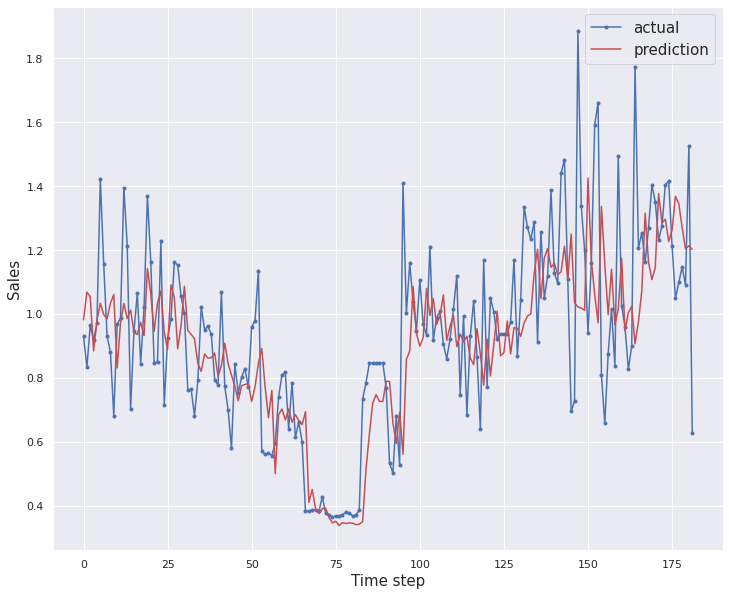

In [ ]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
op = run_lstm(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

In [ ]:

repeats = [10]
epochs = [100, 200]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10    100          0.009  mae
1      10    200          0.009  mae

Train dataset shape- (1246, 1, 7)
Test dataset shape- (182, 1, 7)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling LSTM Model Architecture
Repeat-1
Test RMSE: 0.234
MAPE: 19.806
Model-Loss = 0.130827
Model-Validation-Loss = 0.111892
Repeat-2
Test RMSE: 0.221
MAPE: 17.565
Model-Loss = 0.122199
Model-Validation-Loss = 0.103146
Repeat-3
Test RMSE: 0.222
MAPE: 19.070
Model-Loss = 0.115961
Model-Validation-Loss = 0.105159
Repeat-4
Test RMSE: 0.227
MAPE: 22.411
Model-Loss = 0.113390
Model-Validation-Loss = 0.113241
Repeat-5
Test RMSE: 0.223
MAPE: 19.830
Model-Loss = 0.105506
Model-Validation-Loss = 0.108050
Repeat-6
Test RMSE: 0.226
MAPE: 21.325
Model-Loss = 0.101384
Model-Validation-Loss = 0.111274
Repeat-7
Test RMSE: 0.225
MAPE: 19.402
Model-Loss = 0.097960
Model-Validation-Loss = 0.108473
Repeat-8
Test RMSE: 0.225
MAPE: 18.847
Model-Loss = 0.096566
Model-Validation-Loss = 0.107916

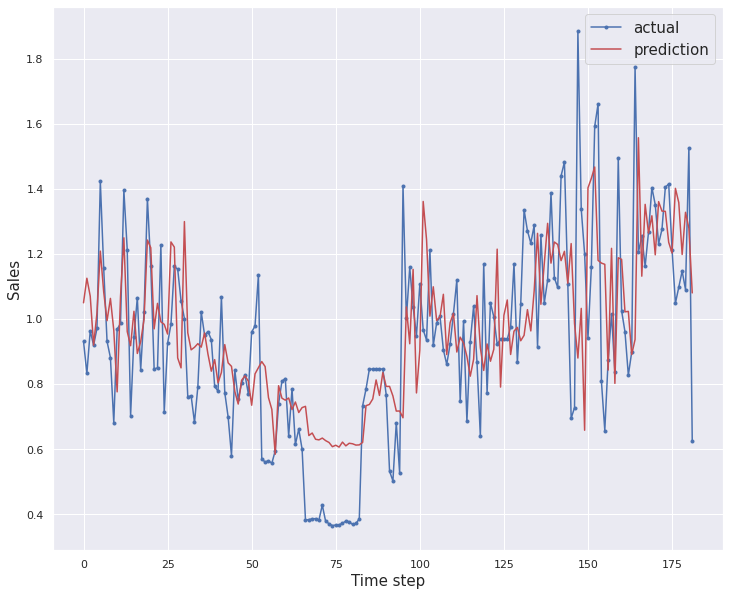

Time Taken for current trial is: 00:04:31
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-200
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling LSTM Model Architecture
Repeat-1
Test RMSE: 0.227
MAPE: 18.540
Model-Loss = 0.120028
Model-Validation-Loss = 0.106145
Repeat-2
Test RMSE: 0.227
MAPE: 19.650
Model-Loss = 0.114457
Model-Validation-Loss = 0.109156
Repeat-3
Test RMSE: 0.232
MAPE: 21.669
Model-Loss = 0.104058
Model-Validation-Loss = 0.113784
Repeat-4
Test RMSE: 0.236
MAPE: 22.747
Model-Loss = 0.097018
Model-Validation-Loss = 0.114426
Repeat-5
Test RMSE: 0.235
MAPE: 21.330
Model-Loss = 0.091142
Model-Validation-Loss = 0.112085
Repeat-6
Test RMSE: 0.253
MAPE: 19.644
Model-Loss = 0.083124
Model-Validation-Loss = 0.117638
Repeat-7
Test RMSE: 0.260
MAPE: 20.365
Model-Loss = 0.081138
Model-Validation-Loss = 0.122640
Repeat-8
Test RM

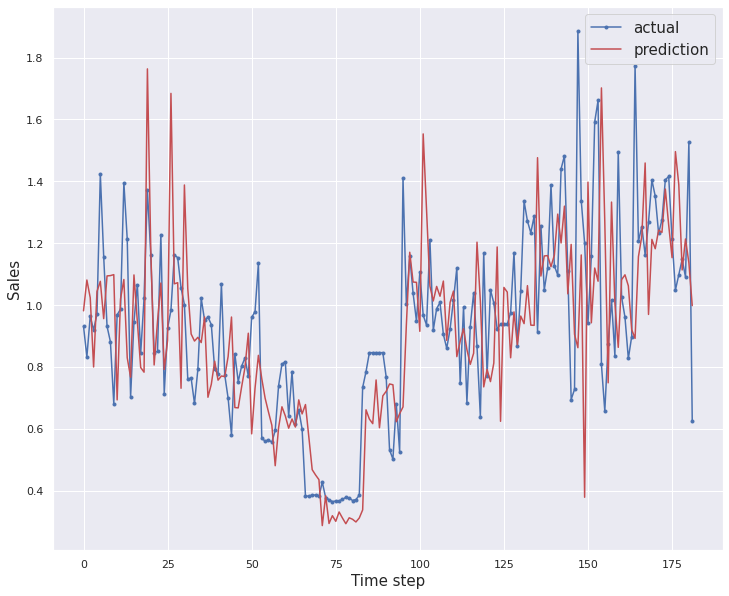

Time Taken for current trial is: 00:07:45
****************************************************************************************************


In [ ]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="LSTM")
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [ ]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)

In [ ]:
history.to_csv("history.csv")

In [ ]:
history.to_excel("history.xlsx", sheet_name = "LSTM")

### Window - 7

In [ ]:
prediction_window = 7

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
print("Shape of reframed dataset-",reframed.shape)
#print(reframed)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1427, 14)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 1, 7) (1239, 7) (182, 1, 7) (182, 7)


Train dataset shape- (1239, 1, 7)
Test dataset shape- (182, 1, 7)
Compiling LSTM Model Architecture
Iteration-1
Test RMSE: 0.262
MAPE: 29.298
Iteration-2
Test RMSE: 0.244
MAPE: 25.486
Iteration-3
Test RMSE: 0.247
MAPE: 26.581
Iteration-4
Test RMSE: 0.250
MAPE: 27.482
Iteration-5
Test RMSE: 0.239
MAPE: 23.495
Iteration-6
Test RMSE: 0.237
MAPE: 24.110
Iteration-7
Test RMSE: 0.246
MAPE: 26.309
Iteration-8
Test RMSE: 0.247
MAPE: 26.538
Iteration-9
Test RMSE: 0.240
MAPE: 23.207
Iteration-10
Test RMSE: 0.243
MAPE: 23.796
Average MAPE for test data over 10 repetitions is 25.6302
Average MAE for test data over 10 repetitions is 0.1999
Average RMSE for test data over 10 repetitions is 0.2456


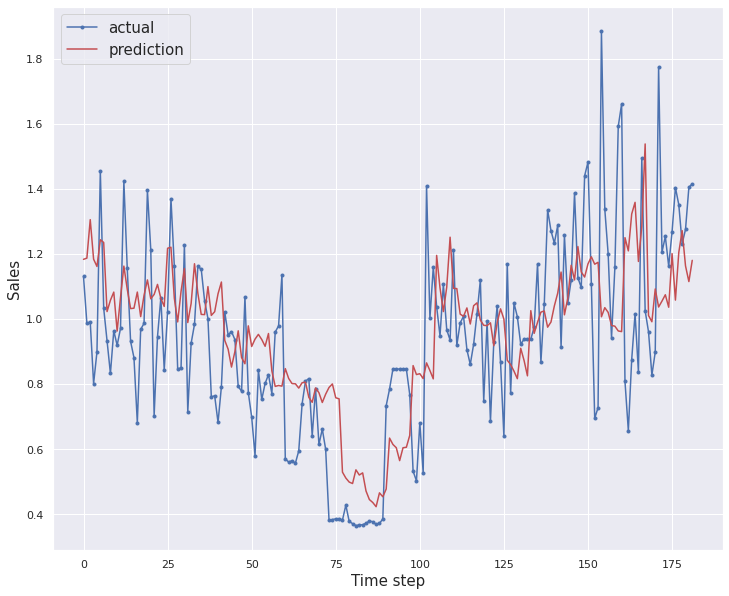

In [ ]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
op = run_lstm(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

Train dataset shape- (1239, 1, 7)
Test dataset shape- (182, 1, 7)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling LSTM Model Architecture
Repeat-1
Test RMSE: 0.238
MAPE: 25.188
Model-Loss = 0.149349
Model-Validation-Loss = 0.123500
Repeat-2
Test RMSE: 0.238
MAPE: 21.326
Model-Loss = 0.142021
Model-Validation-Loss = 0.116721
Repeat-3
Test RMSE: 0.240
MAPE: 23.480
Model-Loss = 0.138092
Model-Validation-Loss = 0.120636
Repeat-4
Test RMSE: 0.245
MAPE: 25.465
Model-Loss = 0.133809
Model-Validation-Loss = 0.125296
Repeat-5
Test RMSE: 0.242
MAPE: 24.871
Model-Loss = 0.134484
Model-Validation-Loss = 0.124194
Repeat-6
Test RMSE: 0.240
MAPE: 24.578
Model-Loss = 0.128302
Model-Validation-Loss = 0.126052
Repeat-7
Test RMSE: 0.237
MAPE: 23.290
Model-Loss = 0.125497
Model-Validation-Loss = 0.122876
Repeat-8
Test RMSE: 0.244
MAPE: 24.427
Model-Loss = 0.123796
Model-Validation-Loss = 0.125568

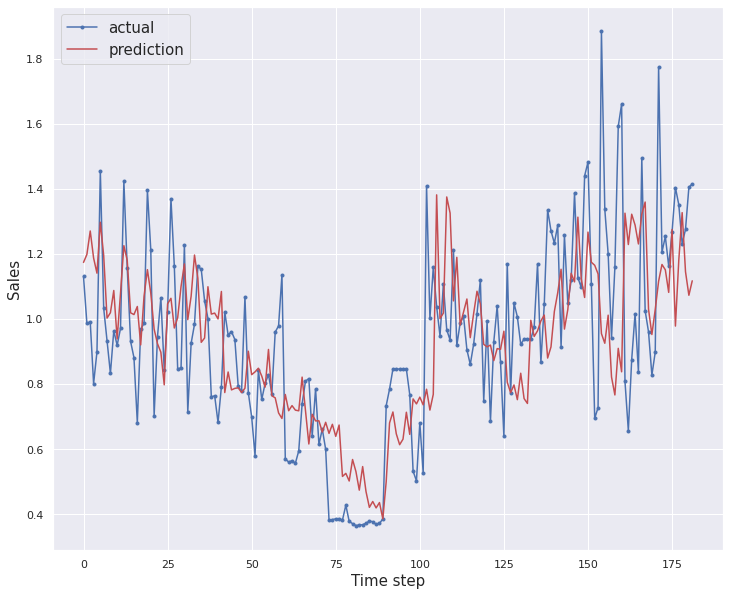

Time Taken for current trial is: 00:03:19
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-200
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling LSTM Model Architecture
Repeat-1
Test RMSE: 0.236
MAPE: 22.133
Model-Loss = 0.142035
Model-Validation-Loss = 0.117390
Repeat-2
Test RMSE: 0.232
MAPE: 22.043
Model-Loss = 0.134527
Model-Validation-Loss = 0.117885
Repeat-3
Test RMSE: 0.230
MAPE: 20.788
Model-Loss = 0.129139
Model-Validation-Loss = 0.118157
Repeat-4
Test RMSE: 0.240
MAPE: 22.004
Model-Loss = 0.124455
Model-Validation-Loss = 0.122829
Repeat-5
Test RMSE: 0.233
MAPE: 20.521
Model-Loss = 0.118469
Model-Validation-Loss = 0.122724
Repeat-6
Test RMSE: 0.232
MAPE: 20.709
Model-Loss = 0.116210
Model-Validation-Loss = 0.122394
Repeat-7
Test RMSE: 0.240
MAPE: 20.972
Model-Loss = 0.115829
Model-Validation-Loss = 0.127370
Repeat-8
Test RM

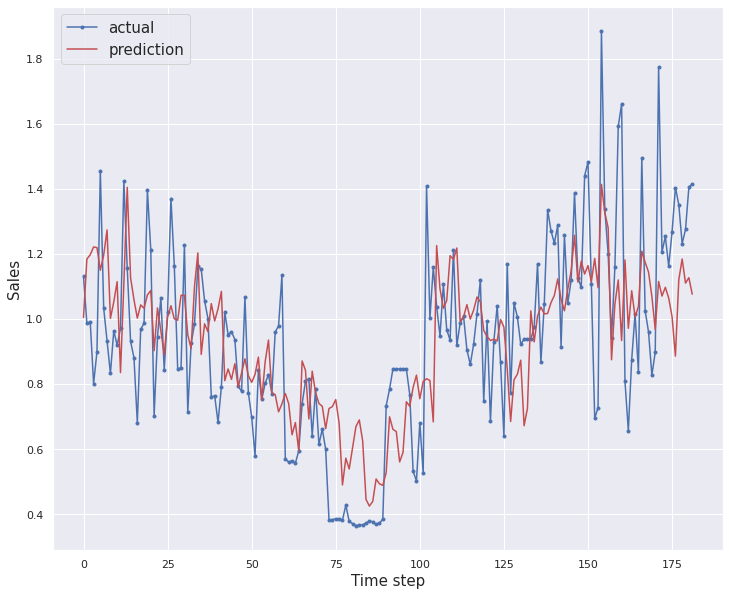

Time Taken for current trial is: 00:06:28
****************************************************************************************************


In [ ]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="LSTM")
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [ ]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)

In [ ]:
history.to_csv("history.csv")

In [ ]:
history.to_excel("history_Window_7.xlsx", sheet_name = "LSTM")

## CNN

### Window - 1

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 7) (1246, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1246, 7, 1)
Test dataset shape- (182, 7, 1)
Compiling CNN Model Architecture
Iteration-1
Test RMSE: 0.245
MAPE: 20.297
Iteration-2
Test RMSE: 0.244
MAPE: 24.627
Iteration-3
Test RMSE: 0.241
MAPE: 20.990
Iteration-4
Test RMSE: 0.248
MAPE: 25.943
Iteration-5
Test RMSE: 0.240
MAPE: 22.151
Iteration-6
Test RMSE: 0.241
MAPE: 22.714
Iteration-7
Test RMSE: 0.243
MAPE: 19.642
Iteration-8
Test RMSE: 0.241
MAPE: 21.987
Iteration-9
Test RMSE: 0.247
MAPE: 20.315
Iteration-10
Test RMSE: 0.248
MAPE: 20.424
Average MAPE for test data over 10 repetitions is 21.9090
Average RMSE for test data over 10 repetitions is 0.2438


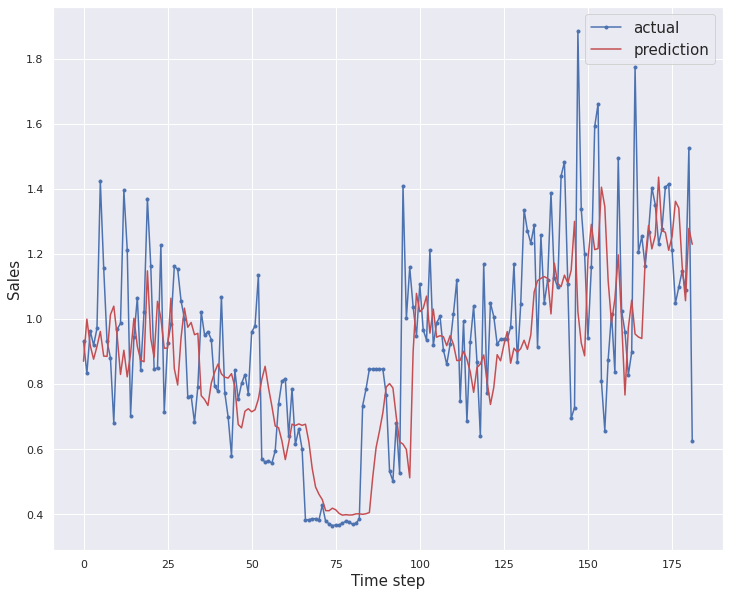

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
op = run_cnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

In [ ]:

repeats = [10]
epochs = [50, 100]
learning_rate = [0.006]
loss_metric = ['mse']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10     50          0.006  mse
1      10    100          0.006  mse

Train dataset shape- (1246, 7, 1)
Test dataset shape- (182, 7, 1)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-50
Learning rate used in model-0.00600
Error metric used in model-mse
Compiling CNN Model Architecture
Repeat-1
Test RMSE: 0.232
MAPE: 20.065
Model-Loss = 0.034702
Model-Validation-Loss = 0.021828
Repeat-2
Test RMSE: 0.247
MAPE: 26.043
Model-Loss = 0.030141
Model-Validation-Loss = 0.024686
Repeat-3
Test RMSE: 0.249
MAPE: 25.115
Model-Loss = 0.028352
Model-Validation-Loss = 0.025042
Repeat-4
Test RMSE: 0.251
MAPE: 23.640
Model-Loss = 0.027157
Model-Validation-Loss = 0.025604
Repeat-5
Test RMSE: 0.258
MAPE: 25.744
Model-Loss = 0.024769
Model-Validation-Loss = 0.026888
Repeat-6
Test RMSE: 0.269
MAPE: 25.947
Model-Loss = 0.023774
Model-Validation-Loss = 0.029279
Repeat-7
Test RMSE: 0.262
MAPE: 21.127
Model-Loss = 0.024000
Model-Validation-Loss = 0.027884
Repeat-8
Test RMSE: 0.257
MAPE: 22.559
Model-Loss = 0.023440
Model-Validation-Loss = 0.026802
R

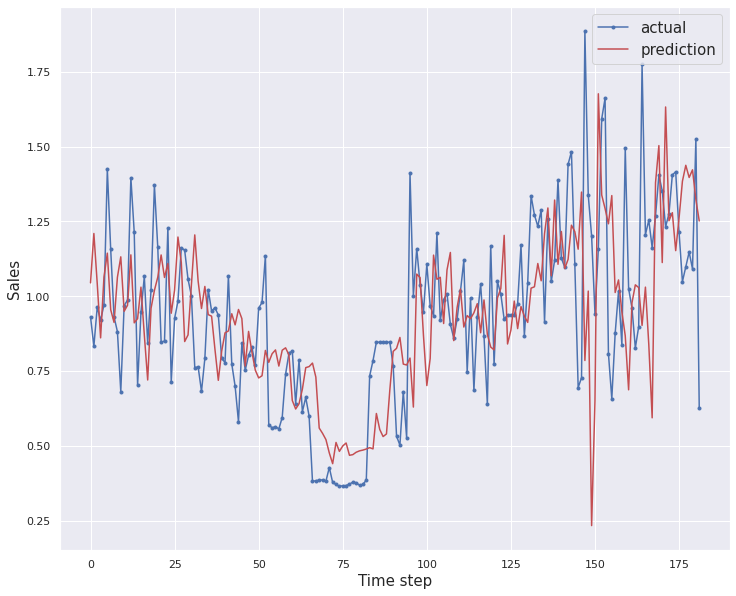

Time Taken for current trial is: 00:02:10
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00600
Error metric used in model-mse
Compiling CNN Model Architecture
Repeat-1
Test RMSE: 0.237
MAPE: 22.528
Model-Loss = 0.029983
Model-Validation-Loss = 0.022773
Repeat-2
Test RMSE: 0.247
MAPE: 21.220
Model-Loss = 0.027004
Model-Validation-Loss = 0.024816
Repeat-3
Test RMSE: 0.264
MAPE: 20.500
Model-Loss = 0.023324
Model-Validation-Loss = 0.028214
Repeat-4
Test RMSE: 0.279
MAPE: 22.884
Model-Loss = 0.020304
Model-Validation-Loss = 0.031667
Repeat-5
Test RMSE: 0.274
MAPE: 23.565
Model-Loss = 0.020005
Model-Validation-Loss = 0.030529
Repeat-6
Test RMSE: 0.278
MAPE: 22.431
Model-Loss = 0.016498
Model-Validation-Loss = 0.031331
Repeat-7
Test RMSE: 0.297
MAPE: 23.477
Model-Loss = 0.017941
Model-Validation-Loss = 0.035656
Repeat-8
Test RMS

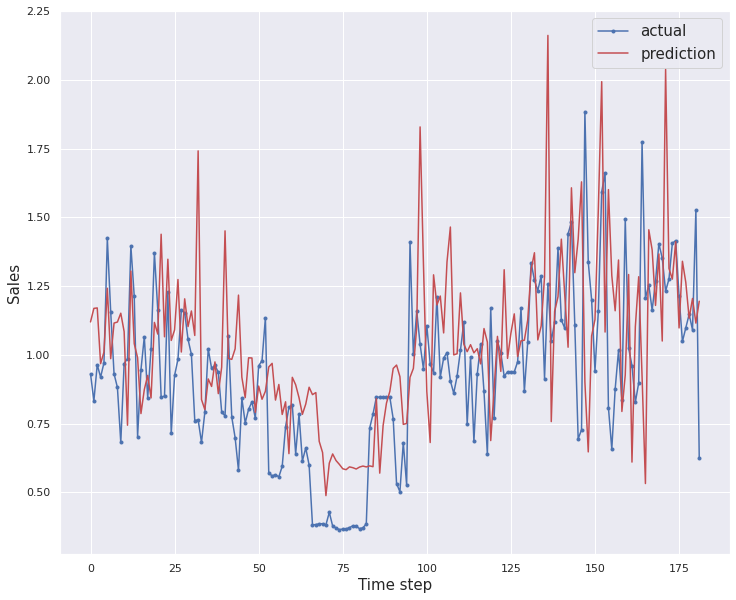

Time Taken for current trial is: 00:02:57
****************************************************************************************************


In [ ]:
model_type = "cnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [ ]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+".xlsx"
!touch "/content/gdrive/My Drive/"+fname

touch: cannot touch '/content/gdrive/My Drive/+fname': No such file or directory


In [ ]:

files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Window - 7

In [42]:
prediction_window = 7

In [43]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1427, 14)


In [44]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [45]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 7) (1239, 7) (182, 7) (182, 7)


In [46]:
# reshape input to be 3D [samples, timesteps, features]
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1239, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1239, 7, 1)
Test dataset shape- (182, 7, 1)
Compiling CNN Model Architecture
Iteration-1
Test RMSE: 0.245
MAPE: 26.058
Iteration-2
Test RMSE: 0.241
MAPE: 24.068
Iteration-3
Test RMSE: 0.250
MAPE: 27.455
Iteration-4
Test RMSE: 0.236
MAPE: 23.415
Iteration-5
Test RMSE: 0.242
MAPE: 25.987
Average MAPE for test data over 5 repetitions is 25.3966
Average RMSE for test data over 5 repetitions is 0.2429


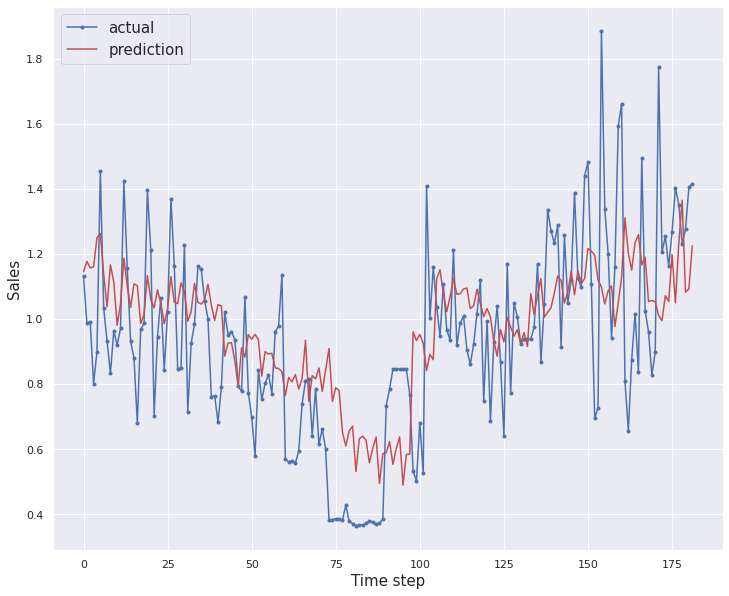

In [47]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_cnn(train, test, n_repeats=5, epochs=20, verbose=0, window=prediction_window)

**Grid**

In [48]:

repeats = [10]
epochs = [50, 100]
learning_rate = [0.006]
loss_metric = ['mse']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10     50          0.006  mse
1      10    100          0.006  mse

Train dataset shape- (1239, 7, 1)
Test dataset shape- (182, 7, 1)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-50
Learning rate used in model-0.00600
Error metric used in model-mse
Compiling CNN Model Architecture
Repeat-1
Test RMSE: 0.242
MAPE: 25.307
Model-Loss = 0.040079
Model-Validation-Loss = 0.024628
Repeat-2
Test RMSE: 0.240
MAPE: 26.787
Model-Loss = 0.037753
Model-Validation-Loss = 0.026695
Repeat-3
Test RMSE: 0.237
MAPE: 24.851
Model-Loss = 0.033921
Model-Validation-Loss = 0.026500
Repeat-4
Test RMSE: 0.244
MAPE: 25.877
Model-Loss = 0.032259
Model-Validation-Loss = 0.027732
Repeat-5
Test RMSE: 0.252
MAPE: 26.648
Model-Loss = 0.031237
Model-Validation-Loss = 0.029601
Repeat-6
Test RMSE: 0.260
MAPE: 27.281
Model-Loss = 0.029741
Model-Validation-Loss = 0.031483
Repeat-7
Test RMSE: 0.260
MAPE: 28.005
Model-Loss = 0.029479
Model-Validation-Loss = 0.030892
Repeat-8
Test RMSE: 0.280
MAPE: 30.589
Model-Loss = 0.028795
Model-Validation-Loss = 0.035816
R

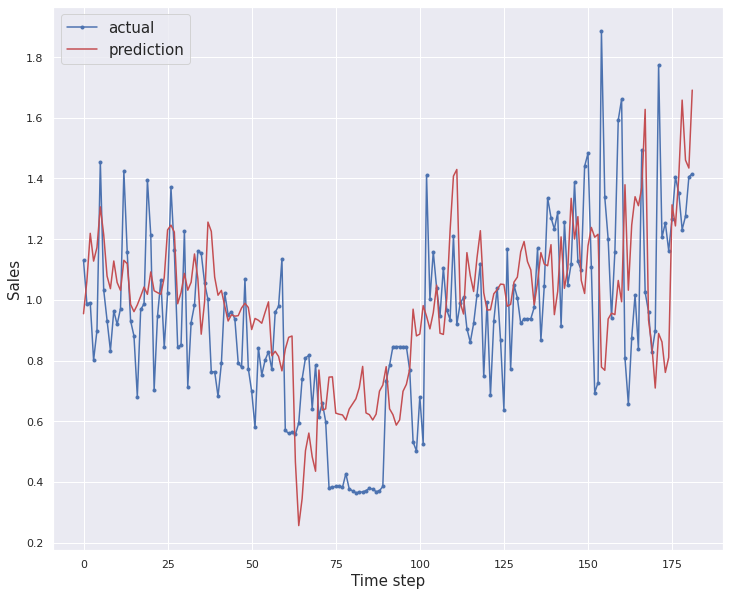

Time Taken for current trial is: 00:00:59
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00600
Error metric used in model-mse
Compiling CNN Model Architecture
Repeat-1
Test RMSE: 0.239
MAPE: 25.728
Model-Loss = 0.038012
Model-Validation-Loss = 0.024920
Repeat-2
Test RMSE: 0.243
MAPE: 25.697
Model-Loss = 0.034522
Model-Validation-Loss = 0.026069
Repeat-3
Test RMSE: 0.248
MAPE: 25.560
Model-Loss = 0.032951
Model-Validation-Loss = 0.027343
Repeat-4
Test RMSE: 0.265
MAPE: 27.803
Model-Loss = 0.031905
Model-Validation-Loss = 0.030446
Repeat-5
Test RMSE: 0.267
MAPE: 27.475
Model-Loss = 0.030568
Model-Validation-Loss = 0.031172
Repeat-6
Test RMSE: 0.274
MAPE: 28.232
Model-Loss = 0.029270
Model-Validation-Loss = 0.031384
Repeat-7
Test RMSE: 0.274
MAPE: 26.875
Model-Loss = 0.029495
Model-Validation-Loss = 0.030335
Repeat-8
Test RMS

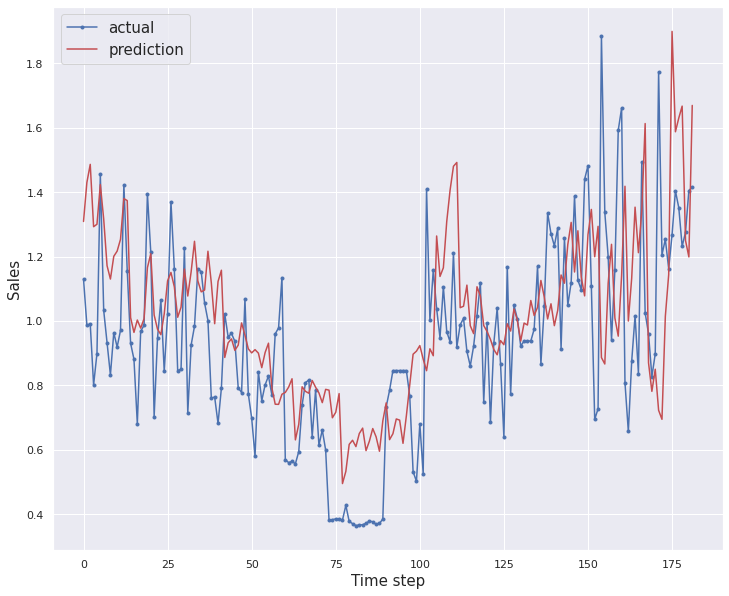

Time Taken for current trial is: 00:03:02
****************************************************************************************************


In [49]:
model_type = "cnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [50]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+".xlsx"
from google.colab import files
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CNN + LSTM

### Window - 1

In [51]:
prediction_window = 1

In [52]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [53]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [54]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 7) (1246, 1) (182, 7) (182, 1)


In [55]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 7, 1)
Validation set shape (182, 7, 1)


In [56]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1246, 1, 7, 1)
Validation set shape (182, 1, 7, 1)


Train dataset shape- (1246, 1, 7, 1)
Test dataset shape- (182, 1, 7, 1)
Compiling CNN-LSTM Model Architecture
Iteration-1
Test RMSE: 0.294
MAPE: 35.153
Iteration-2
Test RMSE: 0.226
MAPE: 20.848
Iteration-3
Test RMSE: 0.228
MAPE: 17.946
Iteration-4
Test RMSE: 0.223
MAPE: 17.627
Iteration-5
Test RMSE: 0.217
MAPE: 18.729
Average MAPE for test data over 5 repetitions is 22.0609
Average RMSE for test data over 5 repetitions is 0.2377


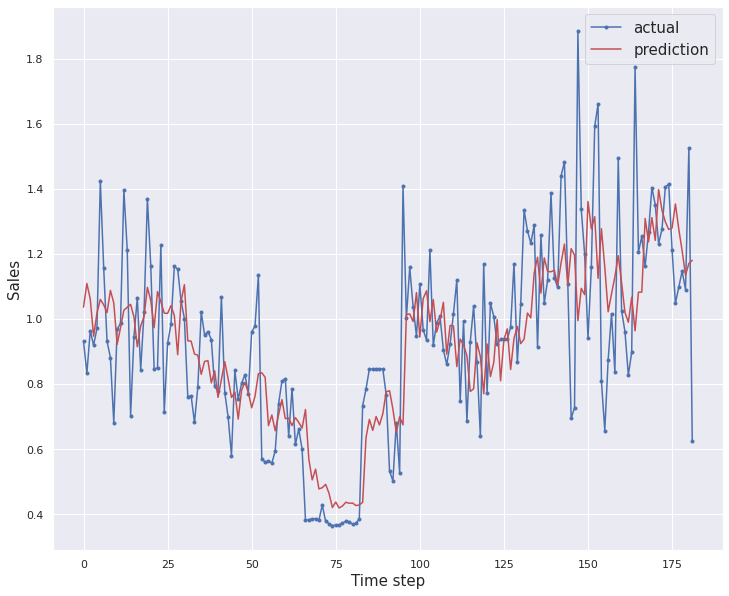

In [57]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
run_cnn_lstm(train, test, n_repeats=5, epochs=20, verbose=0, window=prediction_window)

**Grid**

In [60]:

repeats = [10]
epochs = [50, 100]
learning_rate = [0.008]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10     50          0.008  mae
1      10    100          0.008  mae

Train dataset shape- (1246, 1, 7, 1)
Test dataset shape- (182, 1, 7, 1)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-50
Learning rate used in model-0.00800
Error metric used in model-mae
Compiling CNN-LSTM Model Architecture
Repeat-1
Test RMSE: 0.275
MAPE: 31.816
Model-Loss = 0.140772
Model-Validation-Loss = 0.142836
Repeat-2
Test RMSE: 0.242
MAPE: 20.368
Model-Loss = 0.127013
Model-Validation-Loss = 0.114424
Repeat-3
Test RMSE: 0.238
MAPE: 20.907
Model-Loss = 0.122795
Model-Validation-Loss = 0.113400
Repeat-4
Test RMSE: 0.240
MAPE: 22.055
Model-Loss = 0.120537
Model-Validation-Loss = 0.115910
Repeat-5
Test RMSE: 0.261
MAPE: 26.781
Model-Loss = 0.118430
Model-Validation-Loss = 0.131355
Repeat-6
Test RMSE: 0.274
MAPE: 26.127
Model-Loss = 0.119524
Model-Validation-Loss = 0.131355
Repeat-7
Test RMSE: 0.260
MAPE: 22.694
Model-Loss = 0.110058
Model-Validation-Loss = 0.122154
Repeat-8
Test RMSE: 0.292
MAPE: 28.249
Model-Loss = 0.112161
Model-Validation-Loss =

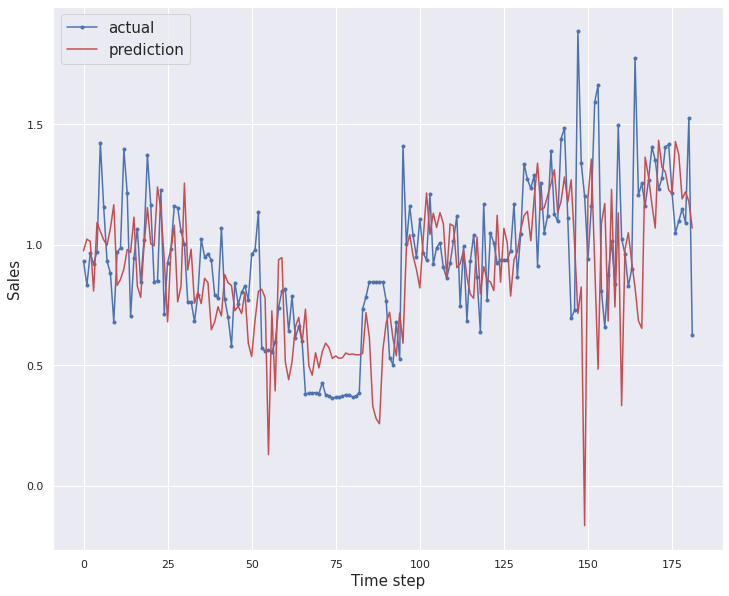

Time Taken for current trial is: 00:03:32
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00800
Error metric used in model-mae
Compiling CNN-LSTM Model Architecture
Repeat-1
Test RMSE: 0.244
MAPE: 25.651
Model-Loss = 0.146206
Model-Validation-Loss = 0.122866
Repeat-2
Test RMSE: 0.274
MAPE: 30.421
Model-Loss = 0.125892
Model-Validation-Loss = 0.139242
Repeat-3
Test RMSE: 0.249
MAPE: 23.561
Model-Loss = 0.116861
Model-Validation-Loss = 0.120595
Repeat-4
Test RMSE: 0.257
MAPE: 22.828
Model-Loss = 0.098040
Model-Validation-Loss = 0.124472
Repeat-5
Test RMSE: 0.262
MAPE: 24.139
Model-Loss = 0.092593
Model-Validation-Loss = 0.129381
Repeat-6
Test RMSE: 0.267
MAPE: 26.325
Model-Loss = 0.089861
Model-Validation-Loss = 0.132813
Repeat-7
Test RMSE: 0.264
MAPE: 22.683
Model-Loss = 0.090244
Model-Validation-Loss = 0.125977
Repeat-8
Tes

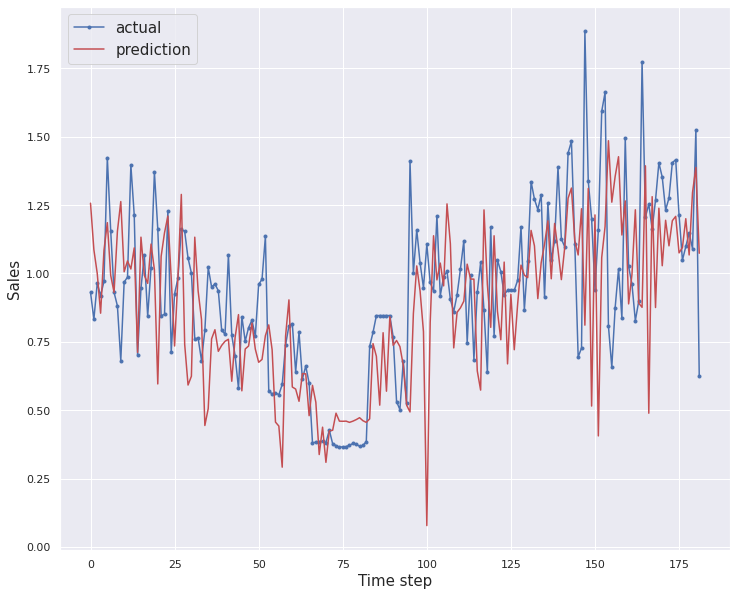

Time Taken for current trial is: 00:05:47
****************************************************************************************************


In [61]:
model_type = "cnn-lstm"
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [62]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+".xlsx"
files.download(fname)

### Window - 7

In [63]:
prediction_window = 7

In [64]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1427, 14)


In [65]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [66]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 7) (1239, 7) (182, 7) (182, 7)


In [67]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1239, 7, 1)
Validation set shape (182, 7, 1)


In [68]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1239, 1, 7, 1)
Validation set shape (182, 1, 7, 1)


Train dataset shape- (1239, 1, 7, 1)
Test dataset shape- (182, 1, 7, 1)
Compiling CNN-LSTM Model Architecture
Repeat-1
Test RMSE: 0.305
MAPE: 36.282
Model-Loss = 0.155949
Model-Validation-Loss = 0.159144
Repeat-2
Test RMSE: 0.291
MAPE: 34.437
Model-Loss = 0.161834
Model-Validation-Loss = 0.151581
Repeat-3
Test RMSE: 0.247
MAPE: 25.562
Model-Loss = 0.147933
Model-Validation-Loss = 0.123980
Repeat-4
Test RMSE: 0.251
MAPE: 27.052
Model-Loss = 0.143954
Model-Validation-Loss = 0.129453
Repeat-5
Test RMSE: 0.247
MAPE: 24.598
Model-Loss = 0.142591
Model-Validation-Loss = 0.123908
Repeat-6
Test RMSE: 0.252
MAPE: 26.679
Model-Loss = 0.143215
Model-Validation-Loss = 0.129205
Repeat-7
Test RMSE: 0.247
MAPE: 22.284
Model-Loss = 0.140058
Model-Validation-Loss = 0.120378
Repeat-8
Test RMSE: 0.251
MAPE: 21.890
Model-Loss = 0.138774
Model-Validation-Loss = 0.121299
Repeat-9
Test RMSE: 0.266
MAPE: 29.131
Model-Loss = 0.138702
Model-Validation-Loss = 0.138208
Repeat-10
Test RMSE: 0.251
MAPE: 24.432
Mode

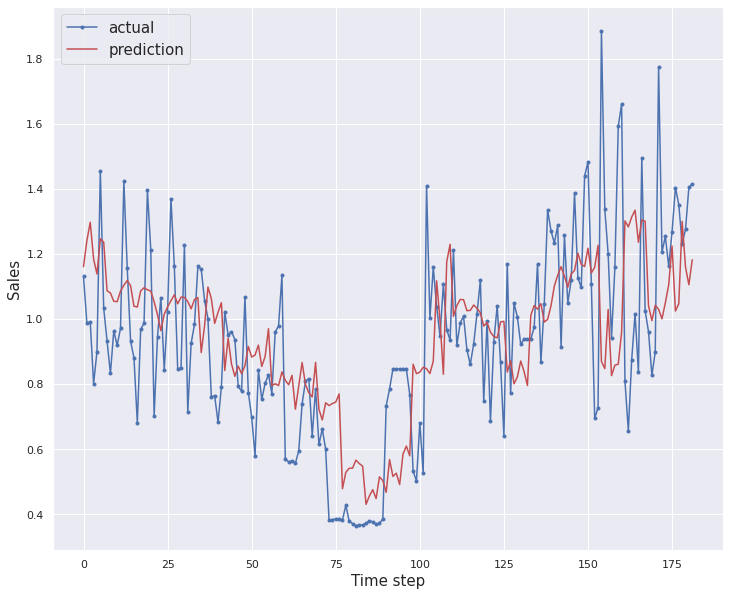

In [69]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
op =run_model(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window, loss='mae', model_type='cnn-lstm')

**Grid**

In [70]:

repeats = [10]
epochs = [50, 100]
learning_rate = [0.008]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10     50          0.008  mae
1      10    100          0.008  mae

Train dataset shape- (1239, 1, 7, 1)
Test dataset shape- (182, 1, 7, 1)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-50
Learning rate used in model-0.00800
Error metric used in model-mae
Compiling CNN-LSTM Model Architecture
Repeat-1
Test RMSE: 0.246
MAPE: 22.298
Model-Loss = 0.146738
Model-Validation-Loss = 0.116933
Repeat-2
Test RMSE: 0.272
MAPE: 30.796
Model-Loss = 0.147440
Model-Validation-Loss = 0.144666
Repeat-3
Test RMSE: 0.249
MAPE: 23.703
Model-Loss = 0.139291
Model-Validation-Loss = 0.121421
Repeat-4
Test RMSE: 0.260
MAPE: 28.592
Model-Loss = 0.133728
Model-Validation-Loss = 0.136452
Repeat-5
Test RMSE: 0.298
MAPE: 34.599
Model-Loss = 0.133780
Model-Validation-Loss = 0.153676
Repeat-6
Test RMSE: 0.298
MAPE: 34.026
Model-Loss = 0.133908
Model-Validation-Loss = 0.150523
Repeat-7
Test RMSE: 0.272
MAPE: 28.700
Model-Loss = 0.132374
Model-Validation-Loss = 0.134778
Repeat-8
Test RMSE: 0.287
MAPE: 30.232
Model-Loss = 0.131932
Model-Validation-Loss =

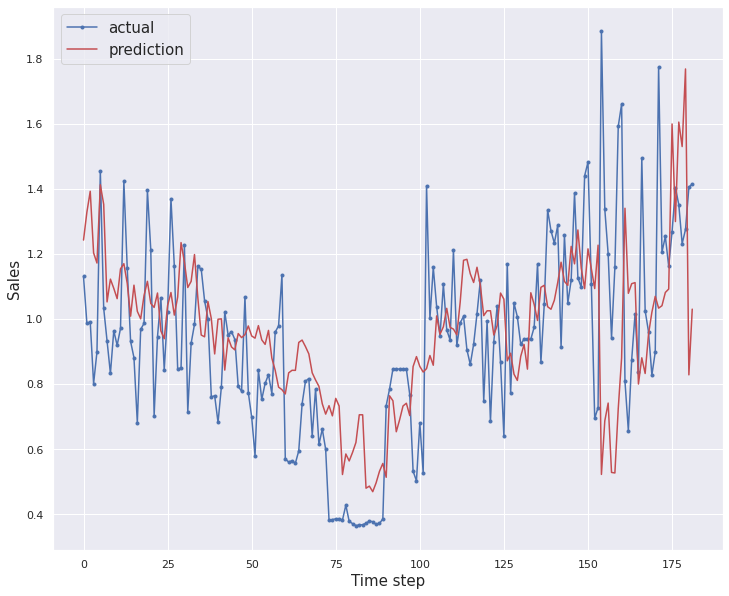

Time Taken for current trial is: 00:01:50
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00800
Error metric used in model-mae
Compiling CNN-LSTM Model Architecture
Repeat-1
Test RMSE: 0.238
MAPE: 23.901
Model-Loss = 0.141157
Model-Validation-Loss = 0.122958
Repeat-2
Test RMSE: 0.270
MAPE: 30.629
Model-Loss = 0.134304
Model-Validation-Loss = 0.143215
Repeat-3
Test RMSE: 0.274
MAPE: 29.438
Model-Loss = 0.128172
Model-Validation-Loss = 0.140022
Repeat-4
Test RMSE: 0.255
MAPE: 26.582
Model-Loss = 0.124966
Model-Validation-Loss = 0.133675
Repeat-5
Test RMSE: 0.248
MAPE: 22.797
Model-Loss = 0.119188
Model-Validation-Loss = 0.126742
Repeat-6
Test RMSE: 0.258
MAPE: 23.053
Model-Loss = 0.116570
Model-Validation-Loss = 0.129890
Repeat-7
Test RMSE: 0.251
MAPE: 23.586
Model-Loss = 0.120042
Model-Validation-Loss = 0.129844
Repeat-8
Tes

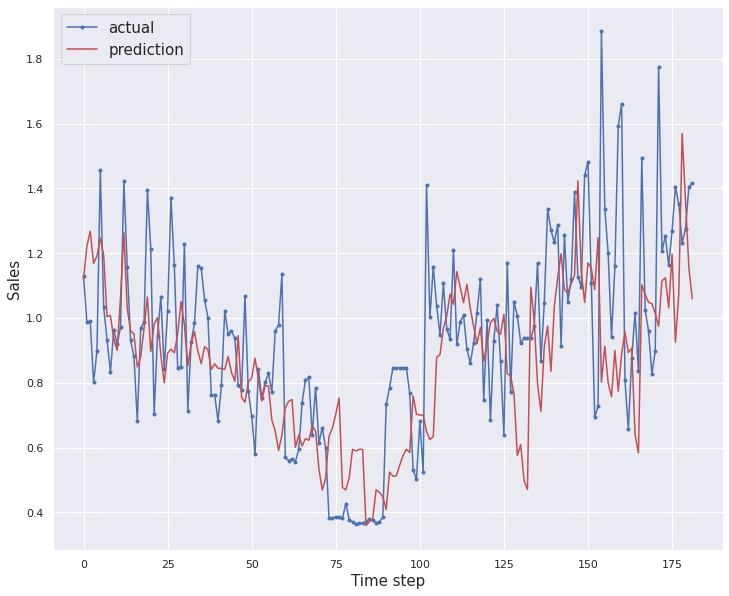

Time Taken for current trial is: 00:03:53
****************************************************************************************************


In [71]:
model_type = "cnn-lstm"
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [72]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TCN

### Window - 1

In [79]:
prediction_window = 1

In [80]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [81]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [82]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 7) (1246, 1) (182, 7) (182, 1)


In [83]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1246, 7, 1)
Test dataset shape- (182, 7, 1)
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.232
MAPE: 18.450
Model-Loss = 0.142886
Model-Validation-Loss = 0.105375
Repeat-2
Test RMSE: 0.229
MAPE: 20.019
Model-Loss = 0.136521
Model-Validation-Loss = 0.107200
Repeat-3
Test RMSE: 0.226
MAPE: 23.772
Model-Loss = 0.133528
Model-Validation-Loss = 0.115132
Repeat-4
Test RMSE: 0.260
MAPE: 28.324
Model-Loss = 0.126817
Model-Validation-Loss = 0.134164
Repeat-5
T

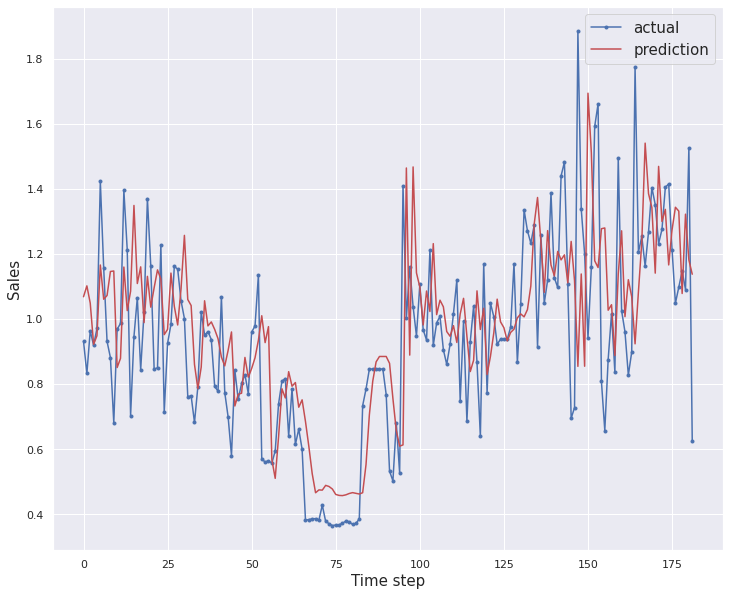

In [84]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
op= run_model(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window,model_type="tcn")

**Grid**

In [85]:

repeats = [10]
epochs = [50, 100]
learning_rate = [0.004]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10     50          0.004  mae
1      10    100          0.004  mae

Train dataset shape- (1246, 7, 1)
Test dataset shape- (182, 7, 1)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-50
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.246
MAPE: 24.148
Model-Loss = 0.120570
Model-Validation-Loss = 0.123168
Repeat-2
Test RMSE: 0.236
MAPE: 23.453
Model-Loss = 0.098700
Model-Validation-Loss = 0.119628
Repeat-3
Test RMSE: 0.231
MAPE: 18.511
Model-Loss 

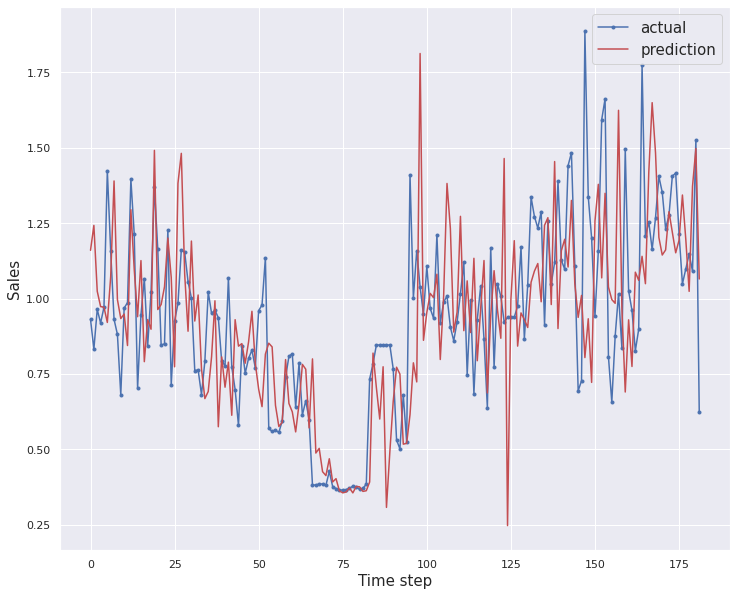

Time Taken for current trial is: 00:07:20
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.241
MAPE: 26.173
Model-Loss = 0.105308
Model-Validation-Loss = 0.127057
Repeat-2
Test RMSE: 0.242
MAPE: 19.761
Model-Loss = 0.077090
Model

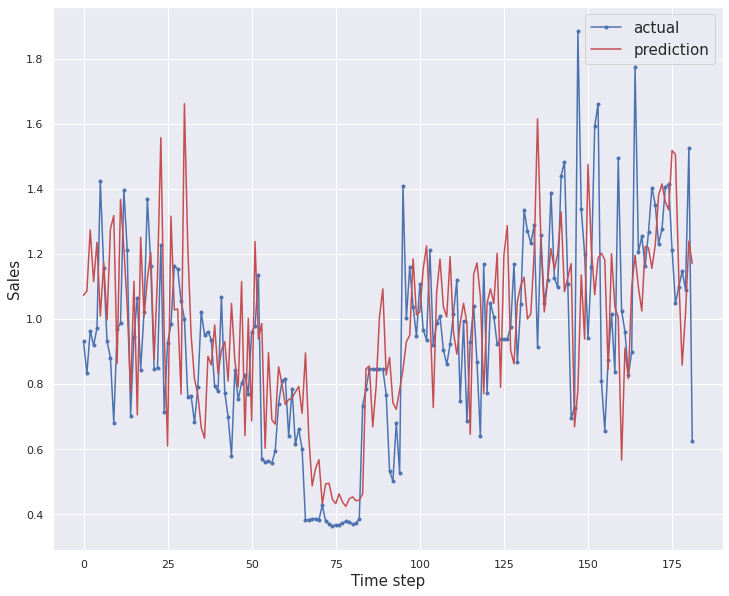

Time Taken for current trial is: 00:12:09
****************************************************************************************************


In [86]:
model_type = "tcn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [87]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:

repeats = [5]
epochs = [50, 100]
learning_rate = [0.004]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0       5     50          0.004  mae
1       5    100          0.004  mae

Train dataset shape- (1246, 7, 1)
Test dataset shape- (182, 7, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-50
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_4 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.230
MAPE: 20.651
Model-Loss = 0.116096
Model-Validation-Loss = 0.110647
Repeat-2
Test RMSE: 0.235
MAPE: 21.654
Model-Loss = 0.096007
Model-Validation-Loss = 0.113668
Repeat-3
Test RMSE: 0.236
MAPE: 18.748
Model-Loss =

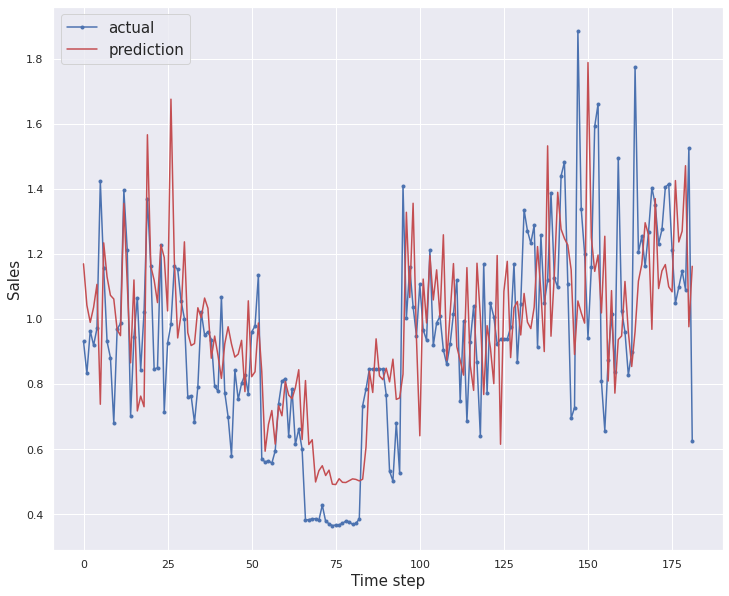

Time Taken for current trial is: 00:03:31
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_5 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.243
MAPE: 24.322
Model-Loss = 0.107363
Model-Validation-Loss = 0.121628
Repeat-2
Test RMSE: 0.228
MAPE: 19.555
Model-Loss = 0.086693
Model-

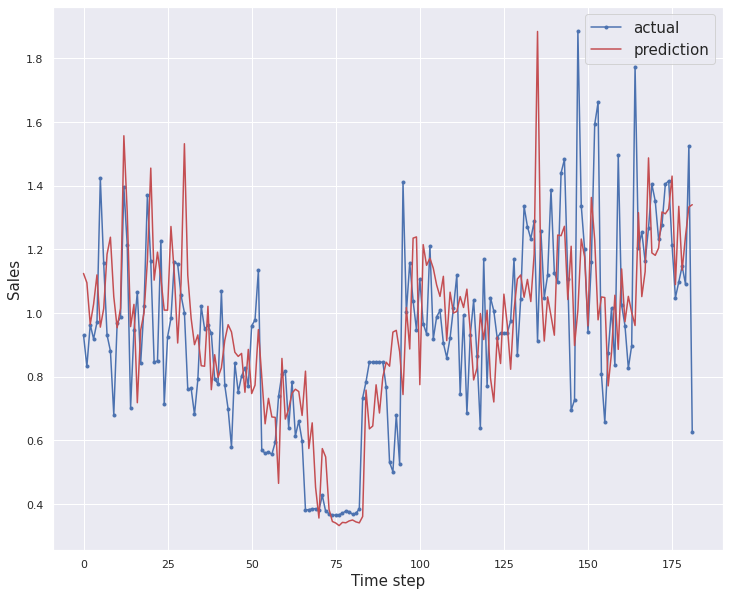

Time Taken for current trial is: 00:06:56
****************************************************************************************************


In [89]:
model_type = "tcn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [90]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

### Window - 7

In [91]:
prediction_window = 7

In [92]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1427, 14)


In [93]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [94]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 7) (1239, 7) (182, 7) (182, 7)


In [95]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1239, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1239, 7, 1)
Test dataset shape- (182, 7, 1)
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_6 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 0.273
MAPE: 28.944
Iteration-2
Test RMSE: 0.274
MAPE: 29.770
Iteration-3
Test RMSE: 0.250
MAPE: 25.126
Iteration-4
Test RMSE: 0.255
MAPE: 27.125
Iteration-5
Test RMSE: 0.255
MAPE: 26.669
Iteration-6
Test RMSE: 0.270
MAPE: 28.753
Iteration-7
Test RMSE: 0.258
MAPE: 23.424
Iteration-8
Test RMSE: 0.246
MAPE: 21.894
Iteration-9
Test RMSE: 0.255
MAPE: 25.587
Iteratio

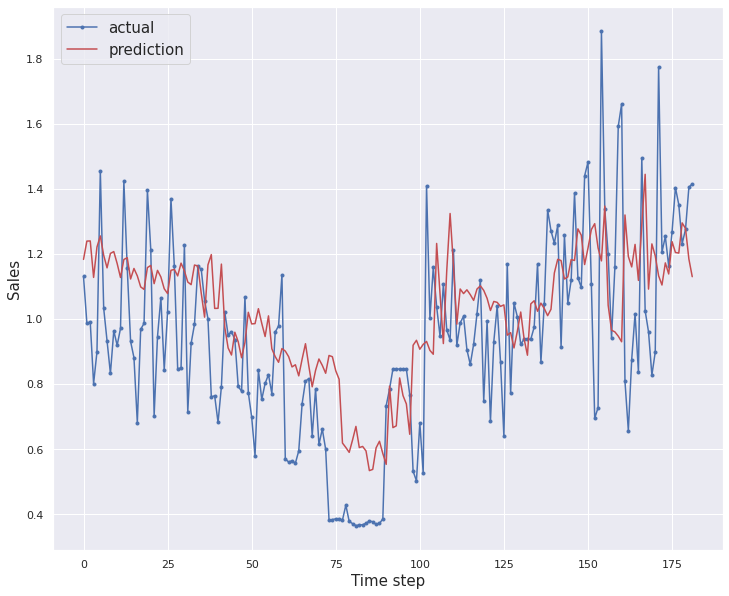

In [96]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_tcn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

**Grid**

In [97]:

repeats = [5]
epochs = [50, 100]
learning_rate = [0.004]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0       5     50          0.004  mae
1       5    100          0.004  mae

Train dataset shape- (1239, 7, 1)
Test dataset shape- (182, 7, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-50
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_7 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.246
MAPE: 23.663
Model-Loss = 0.139838
Model-Validation-Loss = 0.123171
Repeat-2
Test RMSE: 0.238
MAPE: 21.540
Model-Loss = 0.123089
Model-Validation-Loss = 0.119957
Repeat-3
Test RMSE: 0.251
MAPE: 26.699
Model-Loss =

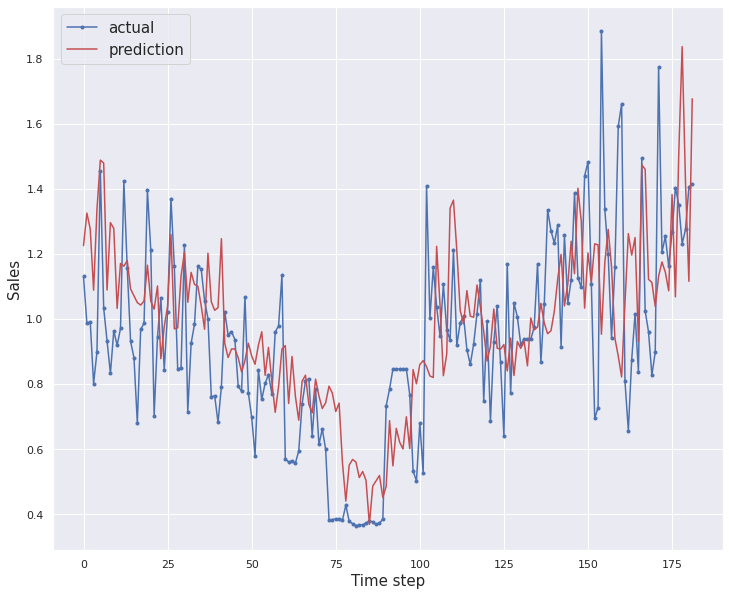

Time Taken for current trial is: 00:03:27
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_8 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_________________________________________________________________
Repeat-1
Test RMSE: 0.241
MAPE: 24.892
Model-Loss = 0.120430
Model-Validation-Loss = 0.128715
Repeat-2
Test RMSE: 0.261
MAPE: 27.056
Model-Loss = 0.097614
Model-

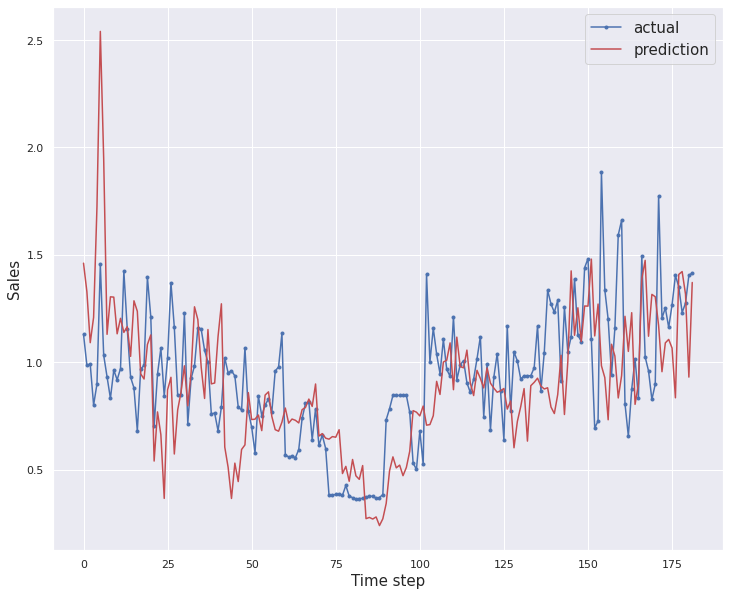

Time Taken for current trial is: 00:07:56
****************************************************************************************************


In [98]:
model_type = "tcn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type=model_type)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [99]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## MACNN

### Window - 1

In [100]:
prediction_window=1

In [101]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 28, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1412, 29)


In [102]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


175

In [103]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1225
182
(1225, 28) (1225, 1) (182, 28) (182, 1)


In [104]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1225, 28, 1)
Validation set shape (182, 28, 1)


#### WO Regularizer

Train dataset shape- (1225, 28, 1)
Test dataset shape- (182, 28, 1)
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 28, 64)       960         s

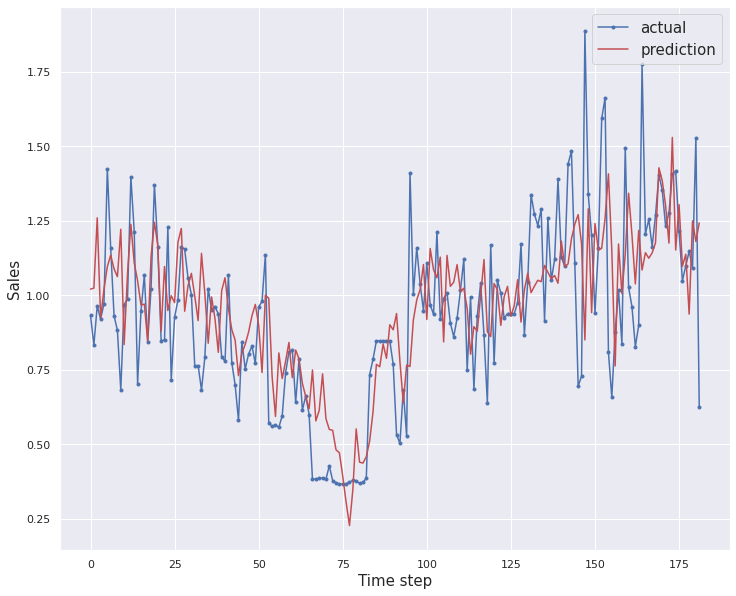

In [105]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, n_in=28, window=prediction_window)

**Grid**

In [107]:

repeats = [5]
epochs = [50, 100]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0       5     50          0.009  mae
1       5    100          0.009  mae

Train dataset shape- (1225, 28, 1)
Test dataset shape- (182, 28, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-50
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________

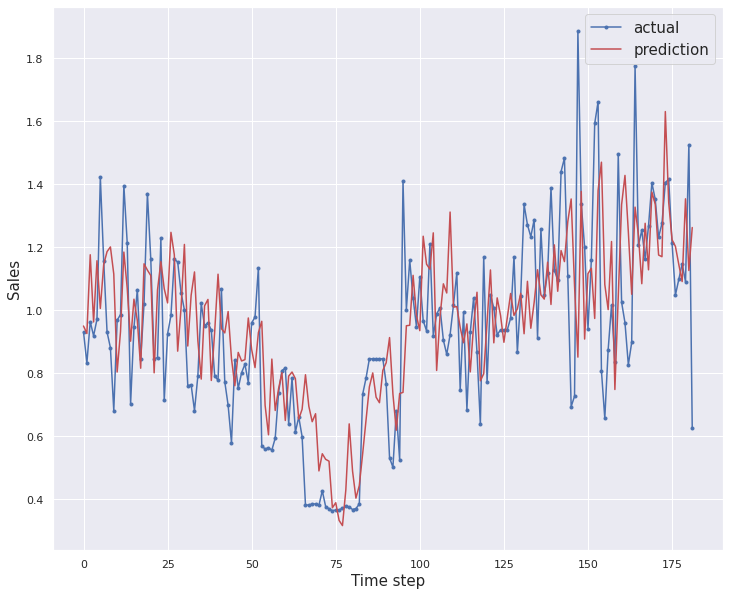

Time Taken for current trial is: 00:03:59
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 28

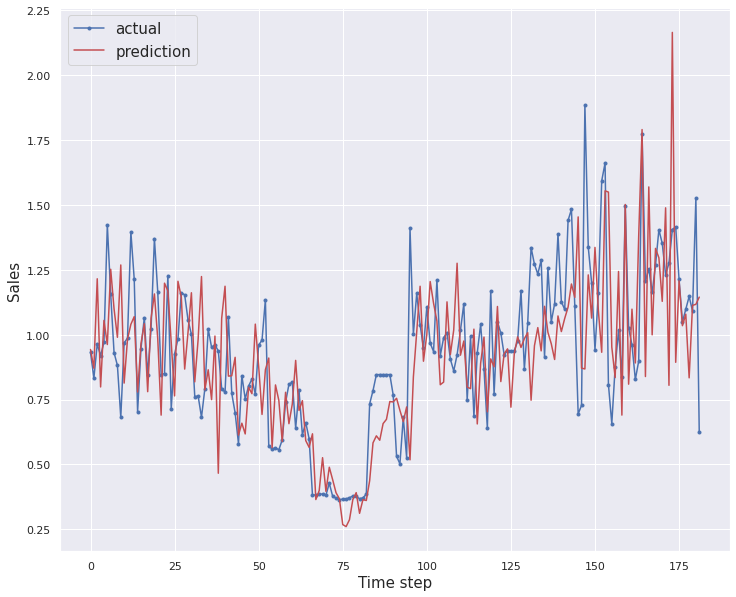

Time Taken for current trial is: 00:06:49
****************************************************************************************************


In [108]:
model_type = "macnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], n_in=28, model_type=model_type, l2_regularizer=False)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [109]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+"_woregularizer"+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+"_woregularizer_"+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### With Regularizer

Train dataset shape- (1225, 28, 1)
Test dataset shape- (182, 28, 1)
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 28, 64)       960         seri

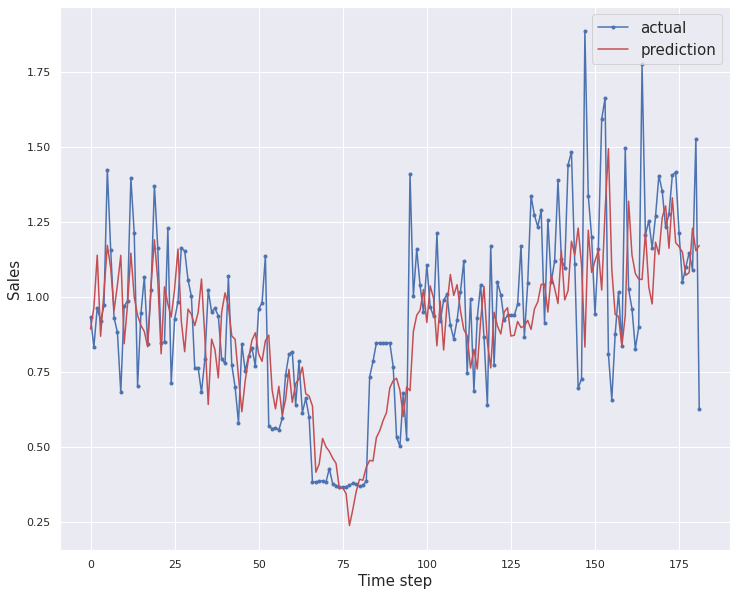

In [110]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window, n_in=28, l2_regularizer=True)

**Grid**

In [113]:

repeats = [5]
epochs = [30, 50]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0       5     30          0.009  mae
1       5     50          0.009  mae

Train dataset shape- (1225, 28, 1)
Test dataset shape- (182, 28, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-30
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
_____________________

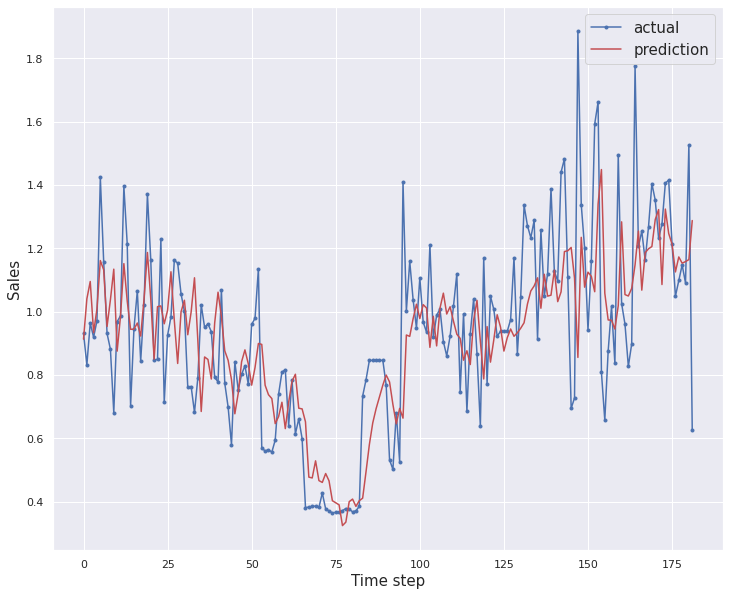

Time Taken for current trial is: 00:02:38
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-5
Epochs used in model-50
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 28, 64

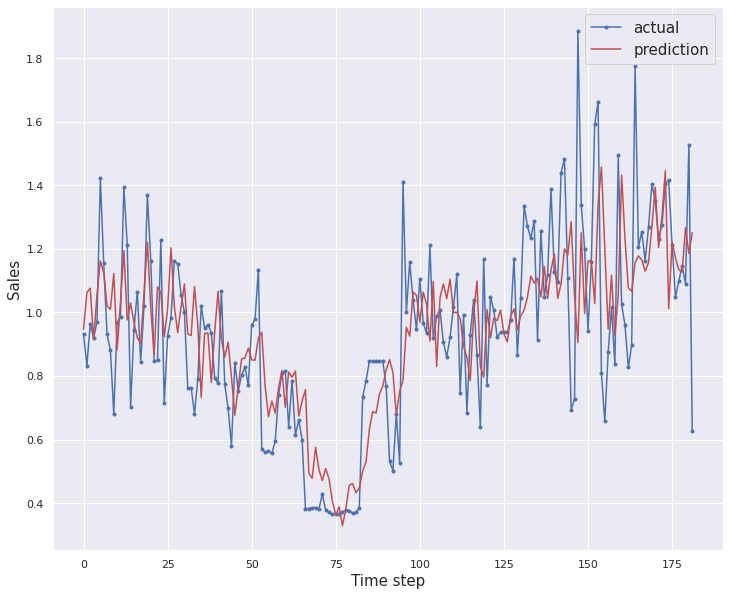

Time Taken for current trial is: 00:03:39
****************************************************************************************************


In [114]:
model_type = "macnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], n_in=28, model_type=model_type, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [115]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+"_withregularizer"+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+"_withregularizer"+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Window - 7

In [116]:
prediction_window=7

In [117]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 28, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1406, 35)


In [118]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


174

In [119]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1218
182
(1218, 28) (1218, 7) (182, 28) (182, 7)


In [120]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1218, 28, 1)
Validation set shape (182, 28, 1)


#### WO Regularizer

Train dataset shape- (1218, 28, 1)
Test dataset shape- (182, 28, 1)
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 28, 64)       960         s

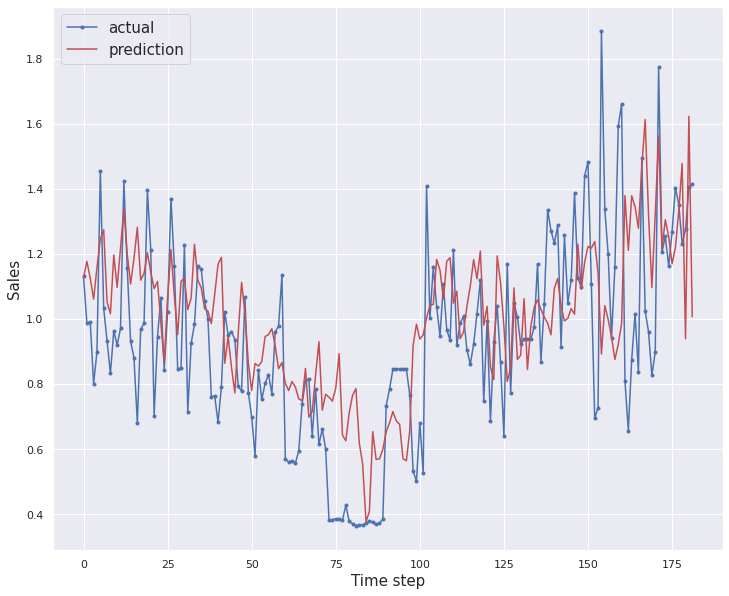

In [121]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, n_in=28, window=prediction_window)

**Grid**

In [122]:

repeats = [5]
epochs = [30, 50]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0       5     30          0.009  mae
1       5     50          0.009  mae

Train dataset shape- (1218, 28, 1)
Test dataset shape- (182, 28, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-30
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________

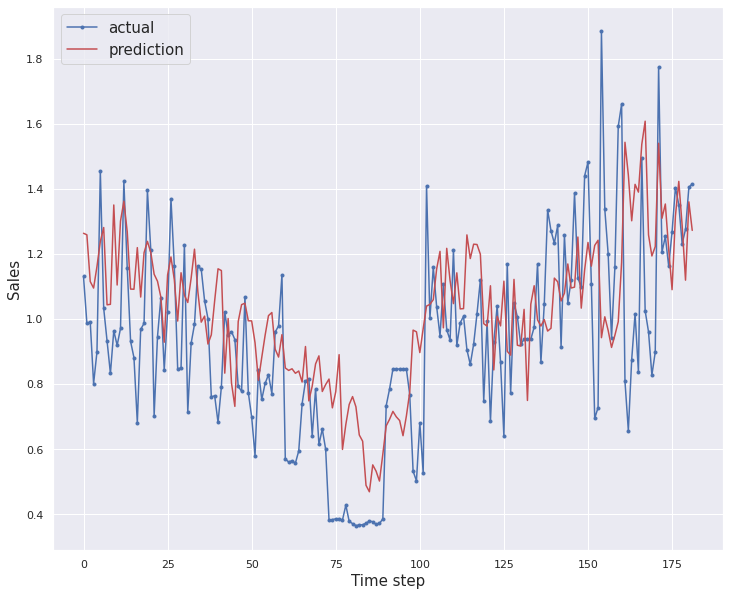

Time Taken for current trial is: 00:03:16
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-5
Epochs used in model-50
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 28,

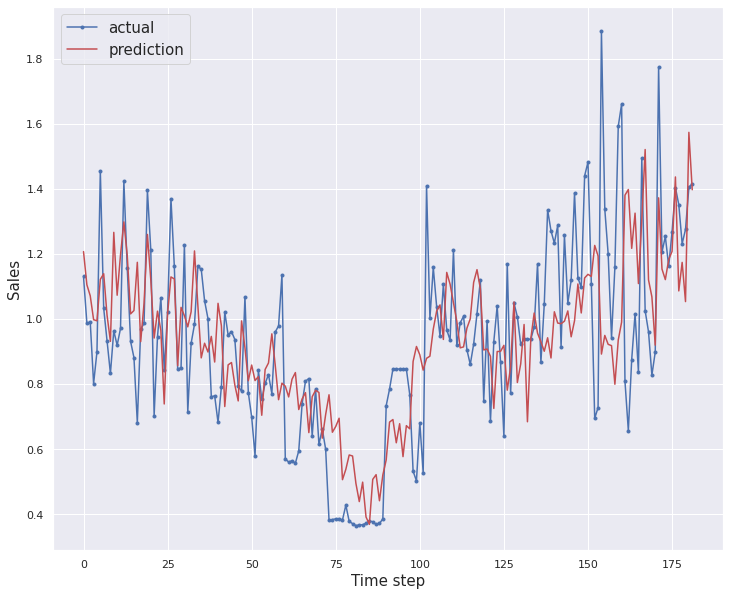

Time Taken for current trial is: 00:04:56
****************************************************************************************************


In [123]:
model_type = "macnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], n_in=28, model_type=model_type, l2_regularizer=False)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [124]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+"_woregularizer"+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+"_woregularizer"+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### With Regularizer

Train dataset shape- (1218, 28, 1)
Test dataset shape- (182, 28, 1)
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_54 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 28, 64)       960         seri

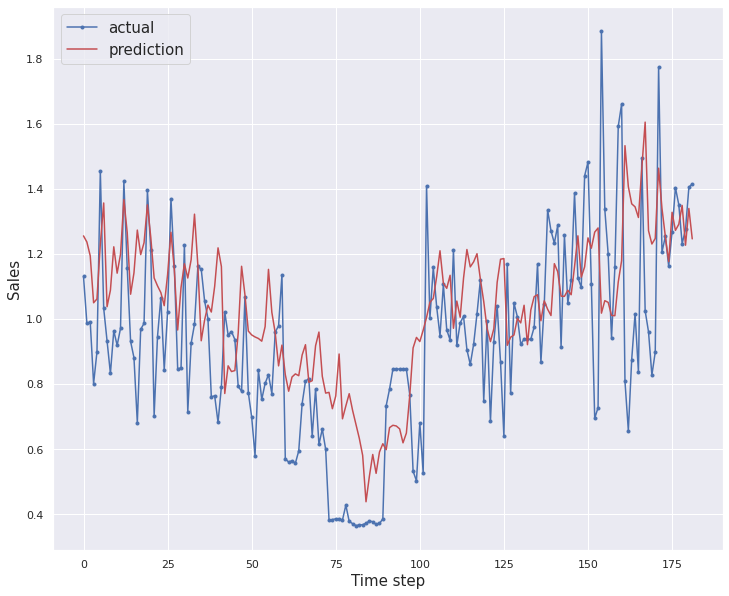

In [125]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window, n_in=28, l2_regularizer=True)

**Grid**

In [126]:

repeats = [5]
epochs = [30, 50]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0       5     30          0.009  mae
1       5     50          0.009  mae

Train dataset shape- (1218, 28, 1)
Test dataset shape- (182, 28, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-30
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
_____________________

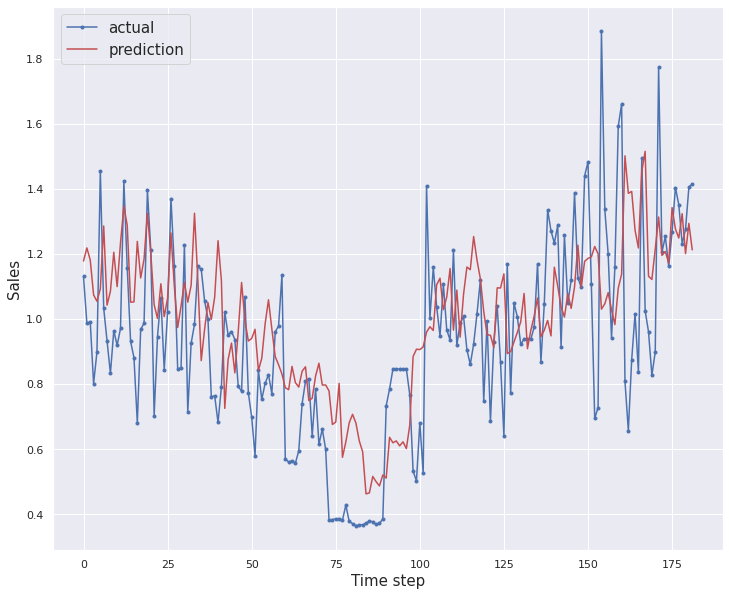

Time Taken for current trial is: 00:01:43
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-5
Epochs used in model-50
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_62 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_63 (Conv1D)              (None, 28, 64

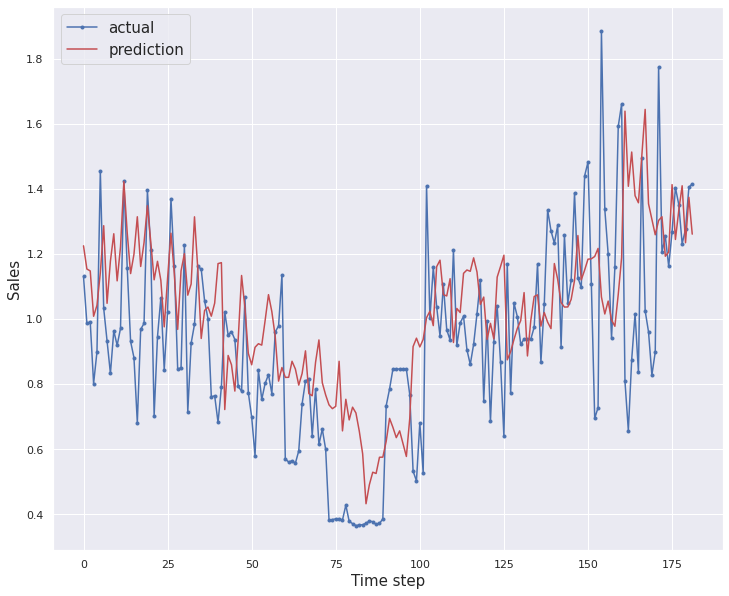

Time Taken for current trial is: 00:03:31
****************************************************************************************************


In [127]:
model_type = "macnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], n_in=28, model_type=model_type, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [128]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+"_withregularizer"+".xlsx", sheet_name = model_type+"_"+str(prediction_window))

In [ ]:
fname= "history_"+model_type+"_"+str(prediction_window)+"_withregularizer"+".xlsx"
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [129]:

repeats = [10]
epochs = [30, 50]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid


repeat  epoch  learning_rate loss
0      10     30          0.009  mae
1      10     50          0.009  mae

Train dataset shape- (1218, 28, 1)
Test dataset shape- (182, 28, 1)
********** Trial-1 **********
Number of repeats tried-10
Epochs used in model-30
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
____________________

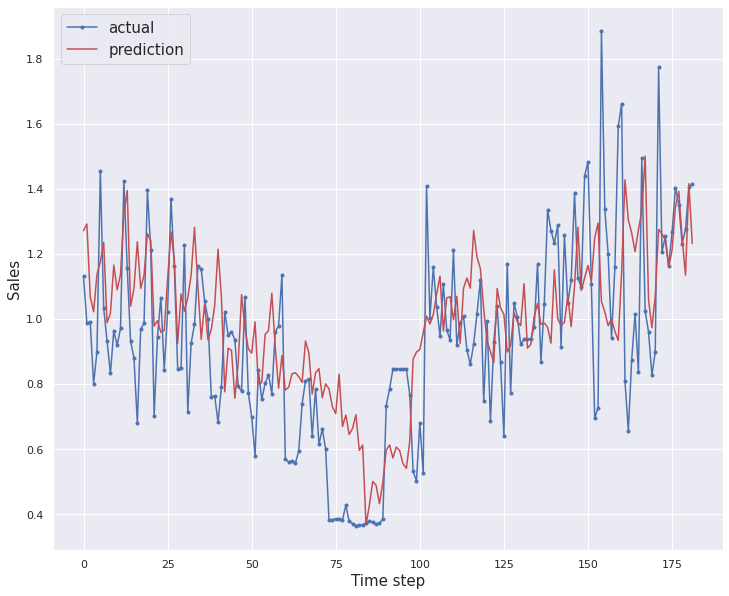

Time Taken for current trial is: 00:03:01
****************************************************************************************************
********** Trial-2 **********
Number of repeats tried-10
Epochs used in model-50
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 28, 6

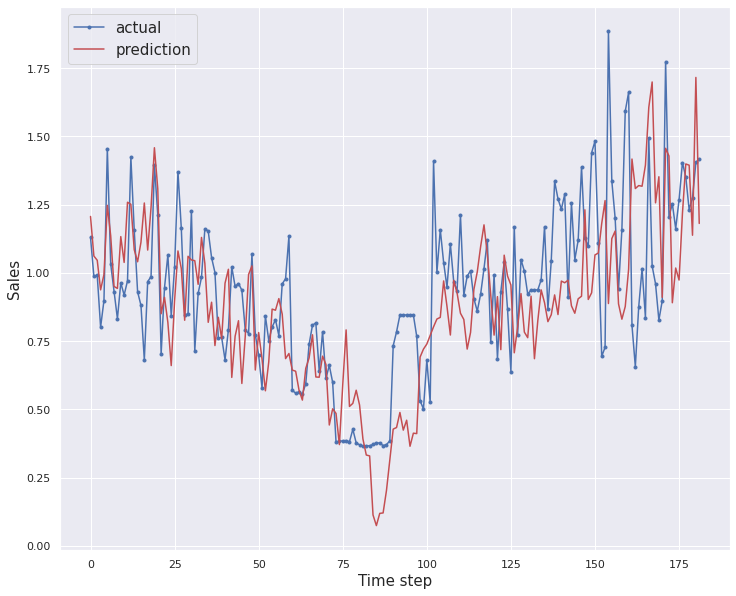

Time Taken for current trial is: 00:05:35
****************************************************************************************************


In [130]:
model_type = "macnn"
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], n_in=28, model_type=model_type, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

In [131]:
history = pd.concat({k: pd.DataFrame(v).T for k, v in trial_history.items()}, axis=0)
history.to_csv("history.csv")
history.to_excel("history_"+model_type+"_"+str(prediction_window)+"_withregularizer"+".xlsx", sheet_name = model_type+"_"+str(prediction_window))